Loading nvda table with features added

In [1]:
import pickle
# load nvda_4 dataset
nvda_4 = pickle.load(open('nvda_with_features.pkl', 'rb'))

selected_features = ['Volatility5', 'Close_to_High10', 'Chaikin_Oscillator', 'Customer_Index_Return', 'DataCenter_Proxy_Return', 'Memory_Momentum_10d', 'ETH_Mining_Proxy']

from IPython.display import display, HTML

display(HTML("""
<style>
.output_scroll {
    overflow-y: scroll;
    height: 200px;   /* Adjust height as needed */
}
</style>
"""))

Redefining LGB training functions for new notebook

In [2]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

def train_lgb_model(X, y, n_splits=5, params=None, num_boost_round=1000, early_stopping_rounds=50):
    """
    Trains and evaluates a LightGBM model using TimeSeriesSplit for regression.
    
    Args:
        X (pd.DataFrame): Features.
        y (pd.Series): Target.
        n_splits (int): Number of time series splits.
        params (dict): LightGBM parameters.
        num_boost_round (int): Maximum number of boosting iterations.
        early_stopping_rounds (int): Early stopping rounds.
    
    Returns:
        list: List of validation RMSE scores for each fold.
    """
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1
        }
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []
    train_rmse_scores = []
    val_std_devs = []  # Store validation target standard deviations
    up_down_accuracies = []  # Store up/down accuracies
    sharpe_ratios = []  # Store Sharpe ratios
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):  # start fold count at 1
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=num_boost_round,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds)]
        )
        
        # Predictions
        val_preds = model.predict(X_val)
        train_preds = model.predict(X_train)
        
        # RMSE calculations
        from sklearn.metrics import root_mean_squared_error
        val_rmse = root_mean_squared_error(y_val, val_preds)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        
        # Standard deviation of validation targets
        val_std = np.std(y_val)
        val_std_devs.append(val_std)
        
        # Up/down accuracy (percentage of times predicted and actual returns had same sign)
        same_sign = np.sign(val_preds) == np.sign(y_val)
        up_down_acc = np.mean(same_sign) * 100  # Convert to percentage
        up_down_accuracies.append(up_down_acc)
        
        # Sharpe ratio (no threshold)
        positions = np.sign(val_preds)
        strategy_returns = positions * y_val
        if strategy_returns.std() > 0:
            sharpe = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())
        else:
            sharpe = 0
        sharpe_ratios.append(sharpe)
        
        # Collect scores
        rmse_scores.append(val_rmse)
        train_rmse_scores.append(train_rmse)
        
        print(f"Fold {fold} - Train RMSE: {train_rmse:.4f} | Validation RMSE: {val_rmse:.4f}")
        print(f"           Validation Std Dev: {val_std:.4f} | Up/Down Accuracy: {up_down_acc:.2f}% | Sharpe: {sharpe:.3f}")
    
    # Plot validation RMSE vs fold
    # Add a second subplot for Sharpe ratios
    plt.figure(figsize=(15, 5))

    # First subplot - existing RMSE plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_splits + 1), rmse_scores, marker='o', linestyle='-', label='Validation RMSE')
    plt.plot(range(1, n_splits + 1), train_rmse_scores, marker='x', linestyle='--', label='Train RMSE')
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.title('Train vs Validation RMSE per Fold')
    plt.legend()
    plt.grid(True)

    # Second subplot - new Sharpe plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_splits + 1), sharpe_ratios, marker='s', linestyle='-', color='green', linewidth=2, markersize=8)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero (no edge)')
    plt.axhline(y=1, color='gold', linestyle='--', alpha=0.5, label='1.0 (good threshold)')
    plt.xlabel('Fold')
    plt.ylabel('Sharpe Ratio')
    plt.title('Sharpe Ratio per Fold')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Average RMSE Gap (Validation - Train): {np.mean(np.array(rmse_scores) - np.array(train_rmse_scores)):.4f}")
    
    # Print overall metrics
    print(f"\n--- Overall Metrics ---")
    print(f"Return volatility: {np.mean(val_std_devs):.4f}")
    print(f"Average up/down accuracy across all folds: {np.mean(up_down_accuracies):.2f}%")
    print(f"Average Sharpe ratio across all folds: {np.mean(sharpe_ratios):.3f}")
    print(f"Average validation RMSE across all folds: {np.mean(rmse_scores):.4f}")
    print(f"Validation RMSE < Validation Std Dev: {sum(rmse < std for rmse, std in zip(rmse_scores, val_std_devs))}/{n_splits} folds")
    
    return rmse_scores, model, sharpe_ratios, up_down_accuracies


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

def train_lgb_model(X, y, n_splits=5, params=None, num_boost_round=1000, early_stopping_rounds=50):
    """
    Trains and evaluates a LightGBM model using TimeSeriesSplit for regression.
    
    Args:
        X (pd.DataFrame): Features.
        y (pd.Series): Target.
        n_splits (int): Number of time series splits.
        params (dict): LightGBM parameters.
        num_boost_round (int): Maximum number of boosting iterations.
        early_stopping_rounds (int): Early stopping rounds.
    
    Returns:
        list: List of validation RMSE scores for each fold.
    """
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1
        }
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []
    train_rmse_scores = []
    val_std_devs = []  # Store validation target standard deviations
    up_down_accuracies = []  # Store up/down accuracies
    sharpe_ratios = []  # Store Sharpe ratios
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):  # start fold count at 1
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=num_boost_round,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds)]
        )
        
        # Predictions
        val_preds = model.predict(X_val)
        train_preds = model.predict(X_train)
        
        # RMSE calculations
        from sklearn.metrics import root_mean_squared_error
        val_rmse = root_mean_squared_error(y_val, val_preds)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        
        # Standard deviation of validation targets
        val_std = np.std(y_val)
        val_std_devs.append(val_std)
        
        # Up/down accuracy (percentage of times predicted and actual returns had same sign)
        same_sign = np.sign(val_preds) == np.sign(y_val)
        up_down_acc = np.mean(same_sign) * 100  # Convert to percentage
        up_down_accuracies.append(up_down_acc)
        
        # Sharpe ratio (no threshold)
        positions = np.sign(val_preds)
        strategy_returns = positions * y_val
        if strategy_returns.std() > 0:
            sharpe = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())
        else:
            sharpe = 0
        sharpe_ratios.append(sharpe)
        
        # Collect scores
        rmse_scores.append(val_rmse)
        train_rmse_scores.append(train_rmse)
        
        print(f"Fold {fold} - Train RMSE: {train_rmse:.4f} | Validation RMSE: {val_rmse:.4f}")
        print(f"           Validation Std Dev: {val_std:.4f} | Up/Down Accuracy: {up_down_acc:.2f}% | Sharpe: {sharpe:.3f}")
    
    # Plot validation RMSE vs fold
    # Add a second subplot for Sharpe ratios
    plt.figure(figsize=(15, 5))

    # First subplot - existing RMSE plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_splits + 1), rmse_scores, marker='o', linestyle='-', label='Validation RMSE')
    plt.plot(range(1, n_splits + 1), train_rmse_scores, marker='x', linestyle='--', label='Train RMSE')
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.title('Train vs Validation RMSE per Fold')
    plt.legend()
    plt.grid(True)

    # Second subplot - new Sharpe plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_splits + 1), sharpe_ratios, marker='s', linestyle='-', color='green', linewidth=2, markersize=8)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero (no edge)')
    plt.axhline(y=1, color='gold', linestyle='--', alpha=0.5, label='1.0 (good threshold)')
    plt.xlabel('Fold')
    plt.ylabel('Sharpe Ratio')
    plt.title('Sharpe Ratio per Fold')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Average RMSE Gap (Validation - Train): {np.mean(np.array(rmse_scores) - np.array(train_rmse_scores)):.4f}")
    
    # Print overall metrics
    print(f"\n--- Overall Metrics ---")
    print(f"Return volatility: {np.mean(val_std_devs):.4f}")
    print(f"Average up/down accuracy across all folds: {np.mean(up_down_accuracies):.2f}%")
    print(f"Average Sharpe ratio across all folds: {np.mean(sharpe_ratios):.3f}")
    print(f"Average validation RMSE across all folds: {np.mean(rmse_scores):.4f}")
    print(f"Validation RMSE < Validation Std Dev: {sum(rmse < std for rmse, std in zip(rmse_scores, val_std_devs))}/{n_splits} folds")
    
    return rmse_scores, model, sharpe_ratios, up_down_accuracies


In [3]:

def train_with_best_params(X, y, best_params, n_splits=5):
    """
    Train final model with best parameters and return detailed results.
    """
    
    # Add fixed parameters to best params
    final_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        **best_params
    }
    
    print(f"\nTraining final model with optimized parameters...")
    print("-" * 50)
    
    # Use your existing train_lgb_model function with optimized parameters
    rmse_scores, final_model = train_lgb_model(
        X, y, 
        n_splits=n_splits, 
        params=final_params,
        num_boost_round=1000,
        early_stopping_rounds=50
    )
    
    return final_model, rmse_scores, final_params

Hyperparameter tuned Model 1 is showing strong potential, however the drop in Sharpe ratio to ~0.5 in fold 2 is concerning.

This occurs during the COVID period, and I believe the issue stems from insufficient regime detection indicators: the model performs exceptionally well during fundamental-driven regime periods but struggles when markets become liquidity-dominated (COVID - fold 2).
 
This makes sense given our 7 current features are entirely short-term momentum/technical based. To address this limitation, I plan to add regime detection indicators by running forward selection with the 10 most impactful regime indicators.

Using a 2-stage forward selection approach: this starts by testing regim features individually and then only test top 5 in combination with original features in order to save time

TWO-STAGE FEATURE SELECTION

[1/4] BASELINE MODEL - 7 Original Features Only
--------------------------------------------------
Features: Original 7 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.0289325
Fold 1 - Train RMSE: 0.0196 | Validation RMSE: 0.0289
           Validation Std Dev: 0.0290 | Up/Down Accuracy: 55.68% | Sharpe: 2.352
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.034993
Fold 2 - Train RMSE: 0.0235 | Validation RMSE: 0.0350
           Validation Std Dev: 0.0350 | Up/Down Accuracy: 52.27% | Sharpe: 1.101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.0278382
Fold 3 - Train RMSE: 0.0255 | Validation RMSE: 0.0278
           Validation Std Dev: 0.0280 | Up/Down Accuracy: 55.00% | Sharpe: 2.341
Training until validation scores don't improve for 50 rou

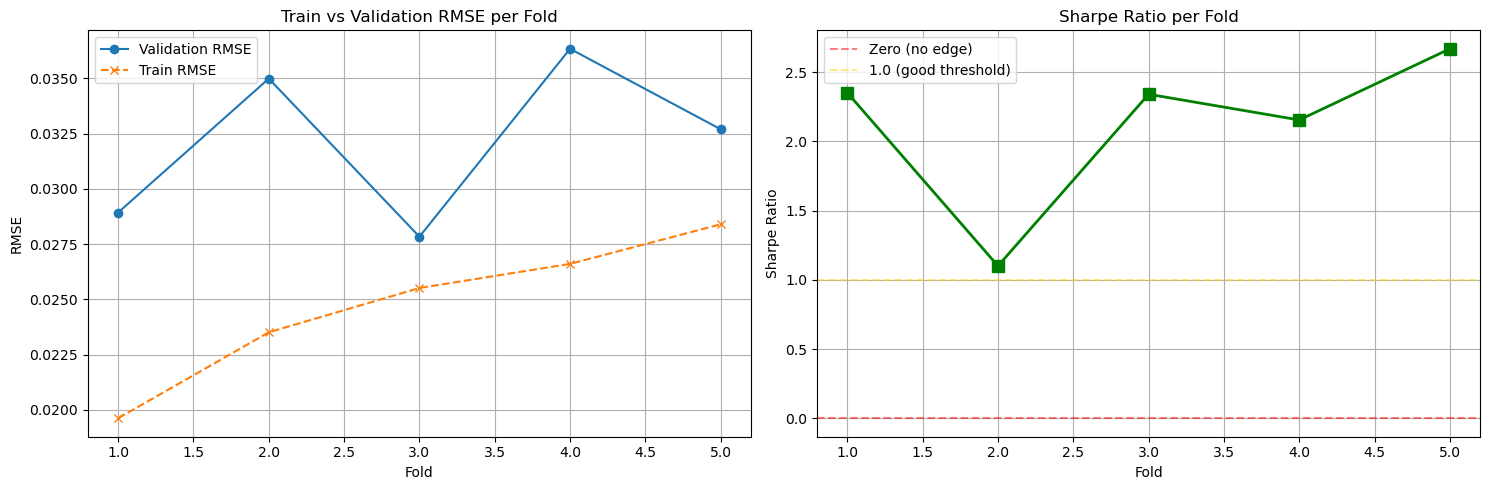

Average RMSE Gap (Validation - Train): 0.0074

--- Overall Metrics ---
Return volatility: 0.0324
Average up/down accuracy across all folds: 54.73%
Average Sharpe ratio across all folds: 2.124
Average validation RMSE across all folds: 0.0322
Validation RMSE < Validation Std Dev: 5/5 folds

Added regime features: None (baseline)

STAGE 1: Testing 9 individual regime features...
--------------------------------------------------


/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus can


Completed Stage 1. Top 5 features: ['DXY_Above_MA', 'Market_Stress_Indicator', 'High_VIX_Regime', 'VIX_Level', 'TNX_Level']

STAGE 2: Testing combinations of top 5 features...
--------------------------------------------------
Testing 31 combinations of top features...


/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/1655210090.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus can

Completed testing 31 combinations

Top 3 combinations found:
  1. ['High_VIX_Regime', 'VIX_Level'] (2 features, Sharpe: 1.8062)
  2. ['DXY_Above_MA', 'VIX_Level'] (2 features, Sharpe: 1.7842)
  3. ['Market_Stress_Indicator', 'VIX_Level'] (2 features, Sharpe: 1.7602)

DETAILED EVALUATION OF TOP 3 COMBINATIONS

[2/4] TOP 1 COMBINATION
--------------------------------------------------
Original 7 features + ['High_VIX_Regime', 'VIX_Level']
Total features: 9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.0289325
Fold 1 - Train RMSE: 0.0208 | Validation RMSE: 0.0289
           Validation Std Dev: 0.0290 | Up/Down Accuracy: 54.32% | Sharpe: 1.246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.0350224
Fold 2 - Train RMSE: 0.0241 | Validation RMSE: 0.0350
           Validation Std Dev: 0.0350 | Up/Down Accuracy: 53.41% | Sharpe: 1.153
Training until vali

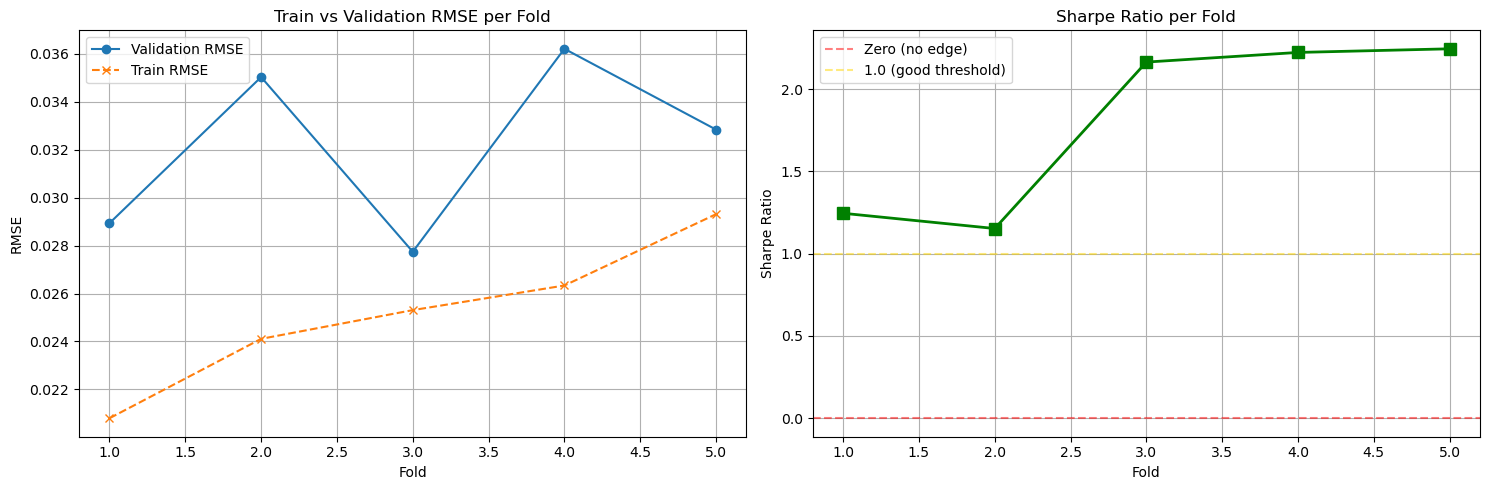

Average RMSE Gap (Validation - Train): 0.0070

--- Overall Metrics ---
Return volatility: 0.0324
Average up/down accuracy across all folds: 54.73%
Average Sharpe ratio across all folds: 1.806
Average validation RMSE across all folds: 0.0321
Validation RMSE < Validation Std Dev: 5/5 folds

Added regime features: ['High_VIX_Regime', 'VIX_Level']

[3/4] TOP 2 COMBINATION
--------------------------------------------------
Original 7 features + ['DXY_Above_MA', 'VIX_Level']
Total features: 9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.0288696
Fold 1 - Train RMSE: 0.0196 | Validation RMSE: 0.0289
           Validation Std Dev: 0.0290 | Up/Down Accuracy: 54.32% | Sharpe: 1.848
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.0350616
Fold 2 - Train RMSE: 0.0240 | Validation RMSE: 0.0351
           Validation Std Dev: 0.0350 | Up/Down Accuracy: 52.05% | 

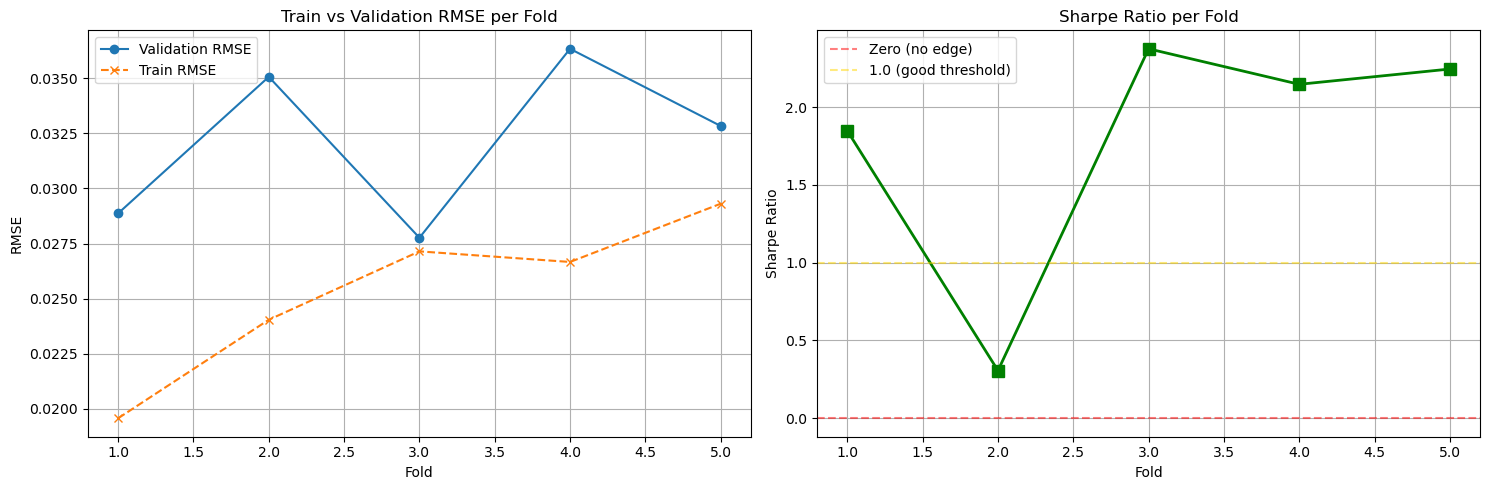

Average RMSE Gap (Validation - Train): 0.0068

--- Overall Metrics ---
Return volatility: 0.0324
Average up/down accuracy across all folds: 54.59%
Average Sharpe ratio across all folds: 1.784
Average validation RMSE across all folds: 0.0322
Validation RMSE < Validation Std Dev: 4/5 folds

Added regime features: ['DXY_Above_MA', 'VIX_Level']

[4/4] TOP 3 COMBINATION
--------------------------------------------------
Original 7 features + ['Market_Stress_Indicator', 'VIX_Level']
Total features: 9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.0287797
Fold 1 - Train RMSE: 0.0201 | Validation RMSE: 0.0288
           Validation Std Dev: 0.0290 | Up/Down Accuracy: 56.36% | Sharpe: 1.777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.0350699
Fold 2 - Train RMSE: 0.0253 | Validation RMSE: 0.0351
           Validation Std Dev: 0.0350 | Up/Down Accuracy: 5

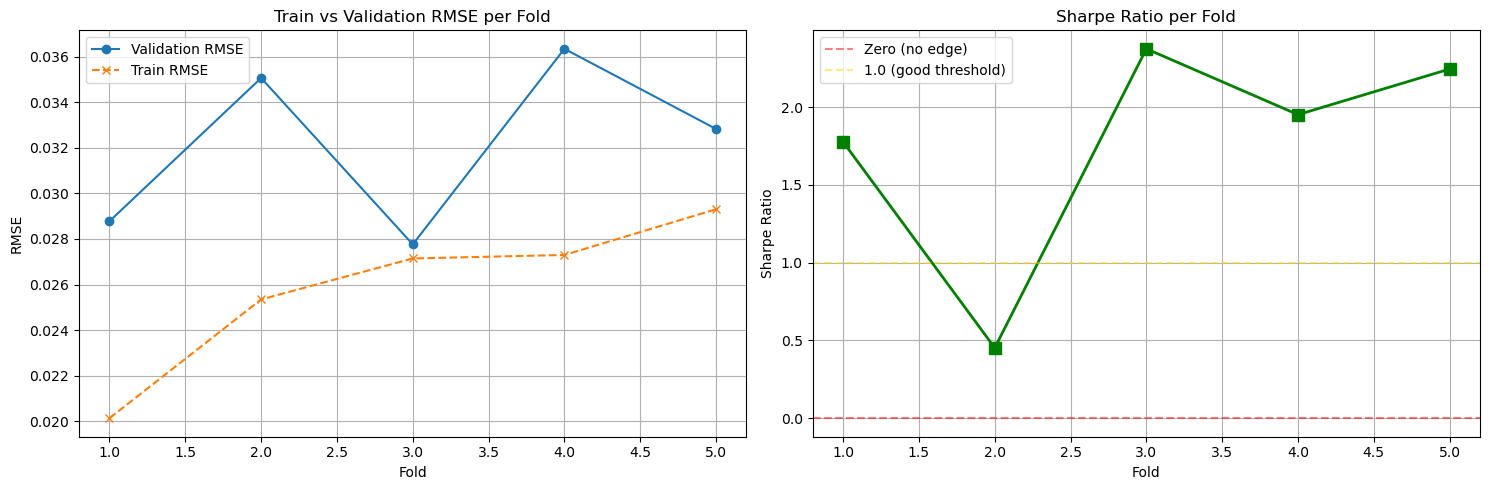

Average RMSE Gap (Validation - Train): 0.0063

--- Overall Metrics ---
Return volatility: 0.0324
Average up/down accuracy across all folds: 55.14%
Average Sharpe ratio across all folds: 1.760
Average validation RMSE across all folds: 0.0322
Validation RMSE < Validation Std Dev: 4/5 folds

Added regime features: ['Market_Stress_Indicator', 'VIX_Level']

FEATURE IMPORTANCE (Best Combination):
--------------------------------------------------
                feature  importance
  Customer_Index_Return    0.230854
        Close_to_High10    0.198681
              VIX_Level    0.104990
    Memory_Momentum_10d    0.078163
            Volatility5    0.066977
       ETH_Mining_Proxy    0.049846
     Chaikin_Oscillator    0.043292
DataCenter_Proxy_Return    0.000000
        High_VIX_Regime    0.000000

SUMMARY:
  Stage 1: Tested 9 individual features
  Stage 2: Tested 31 combinations of top 5
  Total tests: 40 (vs 511 for exhaustive search)


In [4]:
import pandas as pd
import json
import numpy as np
from itertools import combinations
import sys
import os
import matplotlib.pyplot as plt
import matplotlib

# NOTE: You only need to modify your existing train_lgb_model function's return statement:
# Change: return rmse_scores, model
# To: return rmse_scores, model, sharpe_ratios, up_down_accuracies

def forward_feature_selection(nvda_4, selected_features, regime_features, best_params_path, n_splits=5, top_k=5):
    """
    Two-stage approach: Test individual features first, then combinations of top performers.
    
    Args:
        nvda_4 (pd.DataFrame): Full dataset with all features and target
        selected_features (list): Base features to start with (never removed)
        regime_features (list): Additional features to test
        best_params_path (str): Path to JSON file with best parameters
        n_splits (int): Number of time series splits for cross-validation
        top_k (int): Number of top individual features to use for combination testing
    
    Returns:
        dict: Results including best feature combinations and metrics
    """
    
    # Load best parameters
    with open(best_params_path, 'r') as f:
        best_params = json.load(f)
    
    # Add fixed parameters
    final_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        **best_params
    }
    
    # Separate features and target
    y = nvda_4['Return']
    
    print("=" * 80)
    print("TWO-STAGE FEATURE SELECTION")
    print("=" * 80)
    
    # 1. Evaluate baseline model
    print(f"\n[1/4] BASELINE MODEL - {len(selected_features)} Original Features Only")
    print("-" * 50)
    print(f"Features: Original {len(selected_features)} features")
    
    X_baseline = nvda_4[selected_features]
    rmse_scores, model_baseline, sharpe_ratios, up_down_acc = train_lgb_model(
        X_baseline, y, n_splits=n_splits, params=final_params, 
        num_boost_round=1000, early_stopping_rounds=50
    )
    
    baseline_sharpe = np.mean(sharpe_ratios)
    print(f"\nAdded regime features: None (baseline)")
    
    # STAGE 1: Test each regime feature individually
    print(f"\n{'=' * 80}")
    print(f"STAGE 1: Testing {len(regime_features)} individual regime features...")
    print("-" * 50)
    
    individual_scores = []
    
    for i, feature in enumerate(regime_features, 1):
        test_features = selected_features + [feature]
        X_test = nvda_4[test_features]
        
        # Suppress ALL output including plots
        old_backend = matplotlib.get_backend()
        matplotlib.use('Agg')  # Non-interactive backend
        plt.close('all')  # Close any open figures
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        
        try:
            rmse_scores, _, sharpe_ratios, up_down_acc = train_lgb_model(
                X_test, y, n_splits=n_splits, params=final_params,
                num_boost_round=1000, early_stopping_rounds=50
            )
        finally:
            # Always restore output
            sys.stdout = old_stdout
            plt.close('all')  # Close any figures created
            matplotlib.use(old_backend)
        
        avg_sharpe = np.mean(sharpe_ratios)
        
        individual_scores.append({
            'feature': feature,
            'avg_sharpe': avg_sharpe,
            'sharpe_improvement': avg_sharpe - baseline_sharpe
        })
    
    # Sort and get top K performers
    individual_scores.sort(key=lambda x: x['avg_sharpe'], reverse=True)
    top_features = [score['feature'] for score in individual_scores[:top_k]]
    
    print(f"\nCompleted Stage 1. Top {top_k} features: {top_features}")
    
    # STAGE 2: Test combinations of top performers
    print(f"\n{'=' * 80}")
    print(f"STAGE 2: Testing combinations of top {top_k} features...")
    print("-" * 50)
    
    all_combination_scores = []
    total_combinations = 2**len(top_features) - 1
    print(f"Testing {total_combinations} combinations of top features...")
    
    tested = 0
    for r in range(1, len(top_features) + 1):
        for combo in combinations(top_features, r):
            test_features = selected_features + list(combo)
            X_test = nvda_4[test_features]
            
            # Suppress ALL output including plots
            old_backend = matplotlib.get_backend()
            matplotlib.use('Agg')  # Non-interactive backend
            plt.close('all')  # Close any open figures
            old_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')
            
            try:
                rmse_scores, _, sharpe_ratios, up_down_acc = train_lgb_model(
                    X_test, y, n_splits=n_splits, params=final_params,
                    num_boost_round=1000, early_stopping_rounds=50
                )
            finally:
                # Always restore
                sys.stdout = old_stdout
                plt.close('all')  # Close any figures created
                matplotlib.use(old_backend)
            
            avg_sharpe = np.mean(sharpe_ratios)
            
            all_combination_scores.append({
                'features_added': list(combo),
                'n_features_added': len(combo),
                'avg_sharpe': avg_sharpe,
                'sharpe_improvement': avg_sharpe - baseline_sharpe
            })
            
            tested += 1
    
    print(f"Completed testing {tested} combinations")
    
    # Get top 3 combinations overall
    all_combination_scores.sort(key=lambda x: x['avg_sharpe'], reverse=True)
    top_3_combinations = all_combination_scores[:3]
    
    print(f"\nTop 3 combinations found:")
    for i, combo in enumerate(top_3_combinations, 1):
        print(f"  {i}. {combo['features_added']} ({combo['n_features_added']} features, Sharpe: {combo['avg_sharpe']:.4f})")
    
    # 3. Full evaluation of top 3 combinations
    print(f"\n{'=' * 80}")
    print("DETAILED EVALUATION OF TOP 3 COMBINATIONS")
    print("=" * 80)
    
    final_models = []
    
    for i, combo in enumerate(top_3_combinations, 1):
        print(f"\n[{i+1}/4] TOP {i} COMBINATION")
        print("-" * 50)
        print(f"Original {len(selected_features)} features + {combo['features_added']}")
        print(f"Total features: {len(selected_features) + combo['n_features_added']}")
        
        features_combo = selected_features + combo['features_added']
        X_combo = nvda_4[features_combo]
        
        # Full evaluation with output
        rmse_scores, model, sharpe_ratios, up_down_acc = train_lgb_model(
            X_combo, y, n_splits=n_splits, params=final_params,
            num_boost_round=1000, early_stopping_rounds=50
        )
        
        print(f"\nAdded regime features: {combo['features_added']}")
        final_models.append(model)
    
    # Feature importance for best combination
    best_features = selected_features + top_3_combinations[0]['features_added']
    importance = final_models[0].feature_importance(importance_type='gain')
    feature_importance = pd.DataFrame({
        'feature': best_features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f"\n{'=' * 80}")
    print("FEATURE IMPORTANCE (Best Combination):")
    print("-" * 50)
    print(feature_importance.head(10).to_string(index=False))
    
    print(f"\n{'=' * 80}")
    print("SUMMARY:")
    print(f"  Stage 1: Tested {len(regime_features)} individual features")
    print(f"  Stage 2: Tested {total_combinations} combinations of top {top_k}")
    print(f"  Total tests: {len(regime_features) + total_combinations} (vs 511 for exhaustive search)")
    
    return {
        'baseline_features': selected_features,
        'top_3_combinations': top_3_combinations,
        'best_features': best_features,
        'individual_scores': individual_scores,
        'feature_importance': feature_importance,
        'best_model': final_models[0]
    }


# Example usage:
if __name__ == "__main__":
    # Define regime features to test
    regime_features = [
        'VIX_Level', 'Market_Stress_Indicator', 'High_VIX_Regime',
        'VIX_Zscore', 'SP500_Corr_60d', 'DXY_Above_MA',
        'TNX_Level', 'Vol_Regime_High', 'TECH_Corr_60d'
    ]
    
    # Run two-stage selection
results = forward_feature_selection(
         nvda_4=nvda_4,
         selected_features=selected_features,
         regime_features=regime_features,
         best_params_path='best_params.json',
         n_splits=5,
         top_k=5  # Use top 5 features for combination testing
     )

I have explored the effect off adding in long term regim indicators but all it seems to do is hurt model performance in all aspects. 

Thus I have made the decision to move forwards with the initial 7 features. Whilst it does displey a significant drop to ~ 1.05 SHARP during the covid period, this is still a profitable sharp and the other 4 folds show consistent/ high SHARP values. Other measure like up/down accuracy and training/ validation gap are also very consistent/ impressive.

Now I am set on the model it is time to develop a trading strategy

## 📊 Stage 1: Signal Refinement

Converting raw model predictions into actionable trading signals. Not every prediction should become a trade - we identify where our edge is strongest.

### Steps
1. **Baseline Analysis** - Map prediction distribution vs actual returns
2. **Threshold Optimization** - Find cutoffs that maximize risk-adjusted returns  
3. **Asymmetric Testing** - Check if long/short signals need different thresholds
4. **Signal Filtering** - Apply minimum confidence and business rules

### Key Metrics
- Sharpe ratio by prediction strength
- Number of signals generated
- Win rate above/below thresholds
- Average return per signal bucket

BASELINE ANALYSIS - PREDICTION DISTRIBUTION

Prediction Statistics:
  Mean: 0.000023
  Std: 0.023573
  Min: -0.086961
  Max: 0.145408
  Skew: 0.425

EDGE MAP - RETURNS BY PREDICTION STRENGTH
               mean_return  count  win_rate  sharpe  total_return
pred_decile                                                      
D1-Weakest          0.0008     53    0.5283  0.2535        0.0415
D2                 -0.0029     53    0.4340 -0.9586       -0.1543
D3                 -0.0021     53    0.4528 -1.1088       -0.1111
D4                  0.0014     53    0.5472  0.7910        0.0755
D5                  0.0068     53    0.5849  3.2238        0.3609
D6                 -0.0027     52    0.4615 -1.4445       -0.1420
D7                  0.0035     53    0.5283  2.0373        0.1839
D8                  0.0059     53    0.6226  2.7617        0.3123
D9                  0.0073     53    0.5849  3.6275        0.3881
D10-Strongest       0.0080     53    0.5094  3.0058        0.4224

SIMPLE THRESHOLD

/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/4154458706.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_map = df.groupby('pred_decile')['actual_return'].agg([
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/4154458706.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_returns = df.groupby('pred_decile')['actual_return'].mean() * 100
/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/4154458706.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to

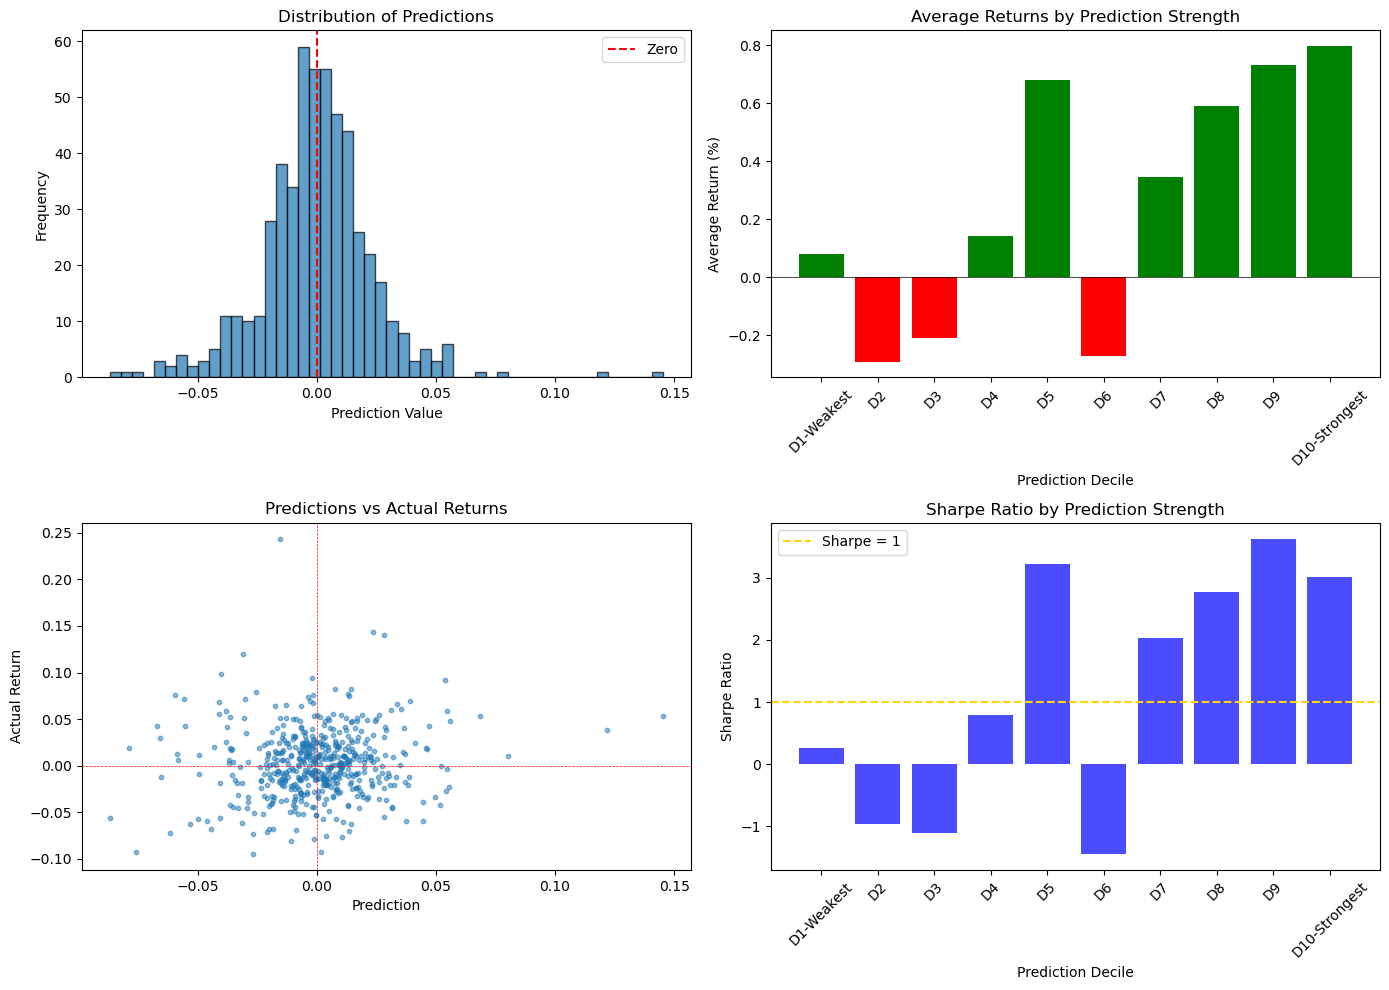


KEY INSIGHTS
✓ Monotonic relationship (higher pred = higher return): False

✓ Best Sharpe deciles: ['D9', 'D5', 'D10-Strongest']

✓ % of signals in extreme deciles (D1, D10): 20.0%

✓ Avg return when pred > 0: 0.412%
✓ Avg return when pred < 0: 0.115%


/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_12793/4154458706.py:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  returns_by_decile = df.groupby('pred_decile')['actual_return'].mean().values


In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

pd.set_option('future.no_silent_downcasting', True)

# Load best parameters
with open('best_params.json', 'r') as f:
   best_params = json.load(f)

# Add fixed parameters
final_params = {
   'objective': 'regression',
   'metric': 'rmse',
   'verbosity': -1,
   'boosting_type': 'gbdt',
   'random_state': 42,
   **best_params
}

# Setup data
X = nvda_4[selected_features]
y = nvda_4['Return']

# Properly split data into train/validation/test
total_len = len(X)
train_end = int(total_len * 0.6)
val_end = int(total_len * 0.8)

# Split the data
X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]  # DON'T USE THIS YET
y_test = y[val_end:]  # DON'T USE THIS YET

# Train model
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
model = lgb.train(
   final_params,
   train_data,
   num_boost_round=1000
)

# Get predictions
predictions = model.predict(X_val)

# Create analysis dataframe
df = pd.DataFrame({
   'prediction': predictions,
   'actual_return': y_val.values
})

# 1. Basic statistics
print("=" * 60)
print("BASELINE ANALYSIS - PREDICTION DISTRIBUTION")
print("=" * 60)
print(f"\nPrediction Statistics:")
print(f"  Mean: {predictions.mean():.6f}")
print(f"  Std: {predictions.std():.6f}")
print(f"  Min: {predictions.min():.6f}")
print(f"  Max: {predictions.max():.6f}")
print(f"  Skew: {pd.Series(predictions).skew():.3f}")

# 2. Bucket analysis - 10 deciles
df['pred_decile'] = pd.qcut(predictions, 10, labels=['D1-Weakest', 'D2', 'D3', 'D4', 'D5', 
                                                     'D6', 'D7', 'D8', 'D9', 'D10-Strongest'])

edge_map = df.groupby('pred_decile')['actual_return'].agg([
   ('mean_return', 'mean'),
   ('count', 'count'),
   ('win_rate', lambda x: (x > 0).mean()),
   ('sharpe', lambda x: np.sqrt(252) * x.mean()/x.std() if x.std() > 0 else 0),
   ('total_return', 'sum')
]).round(4)

print("\n" + "=" * 60)
print("EDGE MAP - RETURNS BY PREDICTION STRENGTH")
print("=" * 60)
print(edge_map)

# 3. Simple threshold analysis
print("\n" + "=" * 60)
print("SIMPLE THRESHOLD ANALYSIS")
print("=" * 60)

thresholds = [0, 0.001, 0.002, 0.003, 0.005, 0.01]
for thresh in thresholds:
   long_signals = df[df['prediction'] > thresh]['actual_return']
   short_signals = df[df['prediction'] < -thresh]['actual_return']
   
   if len(long_signals) > 0:
       long_sharpe = np.sqrt(252) * long_signals.mean()/long_signals.std()
   else:
       long_sharpe = 0
       
   if len(short_signals) > 0:
       short_sharpe = np.sqrt(252) * (-short_signals).mean()/short_signals.std()
   else:
       short_sharpe = 0
   
   print(f"\nThreshold ±{thresh:.3f}:")
   print(f"  Long:  {len(long_signals):3d} signals, Sharpe: {long_sharpe:.2f}, Avg: {long_signals.mean()*100:.3f}%")
   print(f"  Short: {len(short_signals):3d} signals, Sharpe: {short_sharpe:.2f}, Avg: {-short_signals.mean()*100:.3f}%")

# 4. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Prediction distribution
axes[0, 0].hist(predictions, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[0, 0].set_xlabel('Prediction Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Predictions')
axes[0, 0].legend()

# Returns by decile
decile_returns = df.groupby('pred_decile')['actual_return'].mean() * 100
axes[0, 1].bar(range(10), decile_returns.values, color=['red' if x < 0 else 'green' for x in decile_returns.values])
axes[0, 1].set_xticks(range(10))
axes[0, 1].set_xticklabels(decile_returns.index, rotation=45)
axes[0, 1].set_xlabel('Prediction Decile')
axes[0, 1].set_ylabel('Average Return (%)')
axes[0, 1].set_title('Average Returns by Prediction Strength')
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=0.5)

# Scatter plot
axes[1, 0].scatter(predictions, df['actual_return'].values, alpha=0.5, s=10)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=0.5)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=0.5)
axes[1, 0].set_xlabel('Prediction')
axes[1, 0].set_ylabel('Actual Return')
axes[1, 0].set_title('Predictions vs Actual Returns')

# Sharpe by decile
decile_sharpes = df.groupby('pred_decile')['actual_return'].apply(
   lambda x: np.sqrt(252) * x.mean()/x.std() if x.std() > 0 else 0
)
axes[1, 1].bar(range(10), decile_sharpes.values, color='blue', alpha=0.7)
axes[1, 1].set_xticks(range(10))
axes[1, 1].set_xticklabels(decile_sharpes.index, rotation=45)
axes[1, 1].set_xlabel('Prediction Decile')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].set_title('Sharpe Ratio by Prediction Strength')
axes[1, 1].axhline(1, color='gold', linestyle='--', label='Sharpe = 1')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 5. Key insights
print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)

# Check monotonicity
returns_by_decile = df.groupby('pred_decile')['actual_return'].mean().values
is_monotonic = all(returns_by_decile[i] <= returns_by_decile[i+1] for i in range(len(returns_by_decile)-1))
print(f"✓ Monotonic relationship (higher pred = higher return): {is_monotonic}")

# Find best deciles
best_sharpe_deciles = decile_sharpes.nlargest(3)
print(f"\n✓ Best Sharpe deciles: {list(best_sharpe_deciles.index)}")

# Signal concentration
top_bottom_signals = len(df[df['pred_decile'].isin(['D1-Weakest', 'D10-Strongest'])]) / len(df)
print(f"\n✓ % of signals in extreme deciles (D1, D10): {top_bottom_signals*100:.1f}%")

# Edge summary
positive_pred_return = df[df['prediction'] > 0]['actual_return'].mean()
negative_pred_return = df[df['prediction'] < 0]['actual_return'].mean()
print(f"\n✓ Avg return when pred > 0: {positive_pred_return*100:.3f}%")
print(f"✓ Avg return when pred < 0: {negative_pred_return*100:.3f}%")

## 📊 Baseline Analysis Results

### Key Findings
- **Strong but asymmetric edge**: Long signals dominate performance
- **Best signals**: D9 (Sharpe 3.6), D5 (Sharpe 3.2), D10 (Sharpe 3.0) - all long zones
- **Profitable zones**: D5, D7-D10 show consistent positive returns
- **Dead zones**: D2, D3, D6 show negative returns (avoid)
- **Surprise**: D1 weak for shorts (Sharpe 0.25) - model doesn't capture downside well

### Signal Distribution
- Predictions centered near zero with right skew (0.425)
- Most signals fall within [-0.02, 0.02] range
- Extreme deciles (D1, D10) contain 20% of all signals

### Trading Implications
- **LONG**: D5, D7-D10 predictions (moderate to strong positive)
- **SKIP**: D1-D4, D6 (unreliable zones)
- **SHORT**: Consider avoiding - even negative predictions have positive returns!

### Model Characteristic
Non-monotonic relationship suggests model captures complex patterns but struggles with direction on weak signals. Strong long bias evident - possibly trained during bullish period.

### Next Steps
Quick investigation into short failure, then Threshold Optimization

In [6]:
# 1. Check training period performance
train_period_returns = y_train
print(f"Training period stats:")
print(f"  Total return: {train_period_returns.sum()*100:.1f}%")
print(f"  % positive days: {(train_period_returns > 0).mean()*100:.1f}%")
print(f"  Avg up day: {train_period_returns[train_period_returns > 0].mean()*100:.2f}%")
print(f"  Avg down day: {train_period_returns[train_period_returns < 0].mean()*100:.2f}%")

# 2. Compare prediction accuracy on up vs down days
val_results = pd.DataFrame({
    'prediction': predictions,
    'actual': y_val.values,
    'correct_direction': np.sign(predictions) == np.sign(y_val.values)
})

print(f"\nValidation period accuracy:")
print(f"  Accuracy on UP days: {val_results[val_results['actual'] > 0]['correct_direction'].mean()*100:.1f}%")
print(f"  Accuracy on DOWN days: {val_results[val_results['actual'] < 0]['correct_direction'].mean()*100:.1f}%")

# 3. Check if negative predictions are just "less positive"
print(f"\nPrediction distribution by actual outcome:")
print(f"  Avg prediction when market goes UP: {predictions[y_val > 0].mean():.4f}")
print(f"  Avg prediction when market goes DOWN: {predictions[y_val < 0].mean():.4f}")

Training period stats:
  Total return: 411.1%
  % positive days: 55.1%
  Avg up day: 2.00%
  Avg down day: -1.88%

Validation period accuracy:
  Accuracy on UP days: 50.0%
  Accuracy on DOWN days: 52.0%

Prediction distribution by actual outcome:
  Avg prediction when market goes UP: 0.0013
  Avg prediction when market goes DOWN: -0.0014


## 🔍 Short Signal Investigation Results

### Training Period Bias
- Model trained on **411% bull run** - one of NVDA's strongest periods ever
- Despite 45% down days, up days were larger (2.00% vs -1.88%)
- Model learned: "dips are buying opportunities"

### Why Shorts Fail
- Direction accuracy is fine (52% correct on down days)
- But model predicts tiny moves (-0.0014) when NVDA actually crashes
- Trained to expect quick recoveries that happened in training period

### Is This Bad?
**No!** A specialized bull market model with Sharpe 3+ is valuable:
- NVDA has been bullish 70%+ of the time historically
- Long-only strategies avoid borrowing costs and complexity
- Better to excel at one thing than be mediocre at both

### Verdict
Model isn't broken - it's specialized. Like having a Formula 1 car that only turns right but does it brilliantly. Use it for what it's best at: finding long entries in growth stocks.

### Next: Threshold optimization for long-focused strategy

PROPER DATA SPLITTING
Total data points: 2645
Train: 0 to 1587 (60%)
Validation: 1587 to 2116 (20%) - For threshold optimization
Test: 2116 to 2645 (20%) - HOLDOUT for final testing

STAGE 2: THRESHOLD OPTIMIZATION

Validation Set Prediction Statistics:
  Mean: 0.000023
  Std: 0.023573
  Min: -0.086961
  Max: 0.145408

SYMMETRIC THRESHOLD OPTIMIZATION

Optimal Symmetric Threshold: ±0.017755
  Sharpe: 2.689
  Avg Return: 0.706%
  N Trades: 178

ASYMMETRIC THRESHOLD OPTIMIZATION

Optimal Asymmetric Thresholds:
  Long threshold:  0.011053
  Short threshold: 0.017368
  Sharpe: 2.686
  Avg Return: 0.671%
  Total Trades: 238
    Long: 145, Short: 93

PERCENTILE-BASED THRESHOLDS

Optimal Percentile-Based:
  Take top/bottom 15%
  Thresholds: [-0.019430, 0.019653]
  Sharpe: 2.640
  N Trades: 160


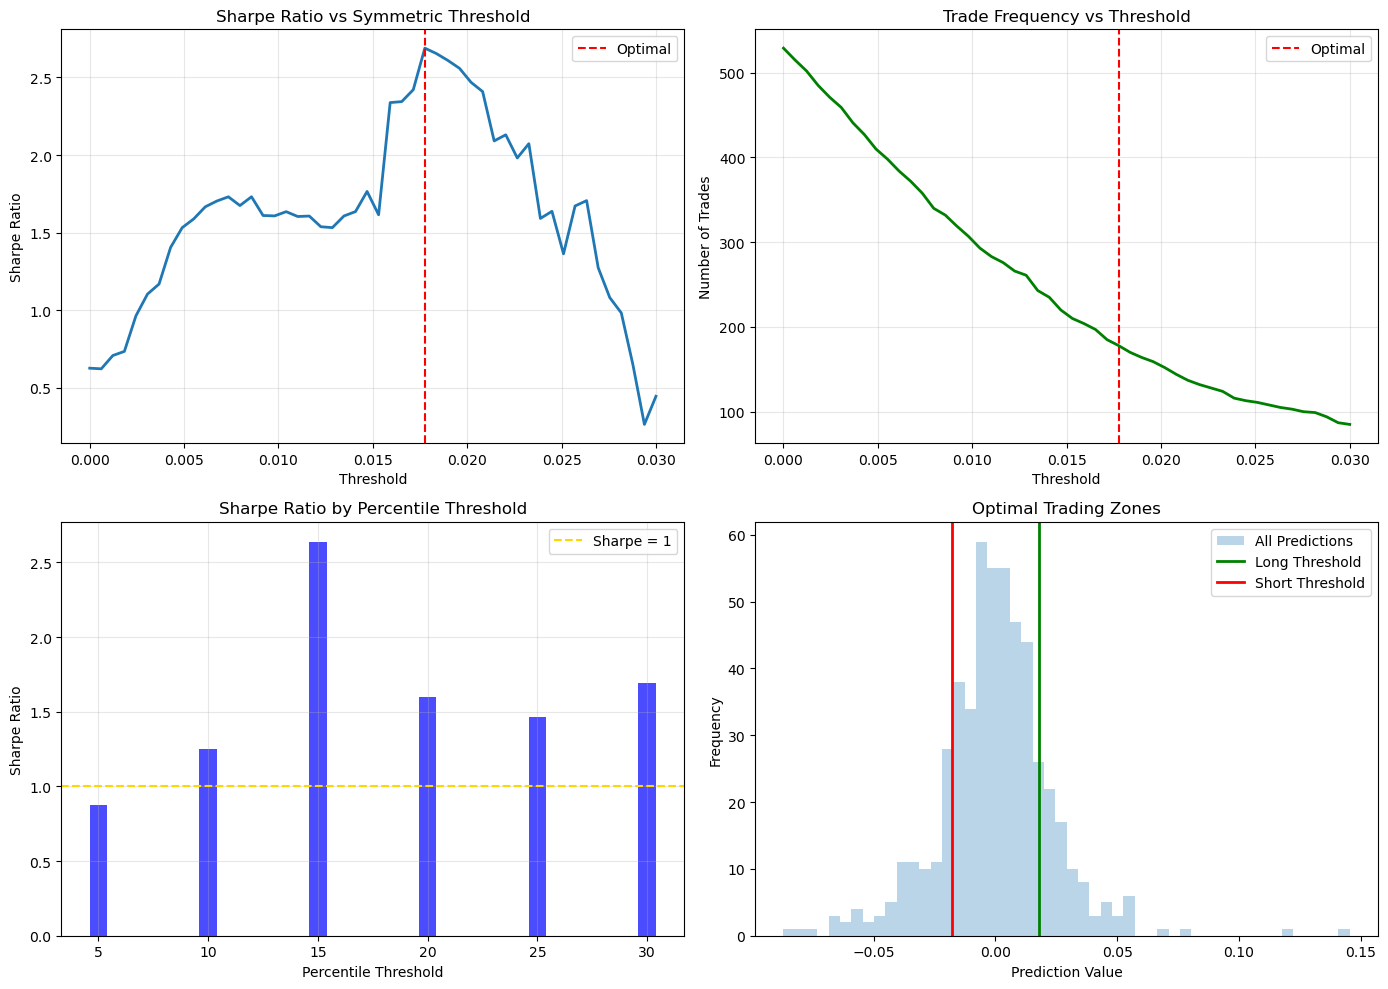


FINAL RECOMMENDATION

✅ BEST METHOD: Symmetric
   Long when prediction > 0.017755
   Short when prediction < -0.017755
   Expected Sharpe: 2.689

📊 With optimal thresholds on validation set:
   Long signals: 87 trades, 55.2% win rate
   Short signals: 91 trades, 54.9% win rate
   Total signals: 178 (33.6% of all predictions)

💾 Thresholds saved to 'optimal_thresholds' dictionary

⚠️ IMPORTANT: Test set (529 samples) remains untouched for final validation
   This ensures no look-ahead bias in your results!


In [7]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# =======================
# DATA SPLIT FIX - AVOID LOOK-AHEAD BIAS
# =======================

print("=" * 60)
print("PROPER DATA SPLITTING")
print("=" * 60)

# Load best parameters
with open('best_params.json', 'r') as f:
   best_params = json.load(f)

# Add fixed parameters
final_params = {
   'objective': 'regression',
   'metric': 'rmse',
   'verbosity': -1,
   'boosting_type': 'gbdt',
   'random_state': 42,
   **best_params
}

# Properly split data into train/validation/test
total_len = len(nvda_4)
train_end = int(total_len * 0.6)
val_end = int(total_len * 0.8)

print(f"Total data points: {total_len}")
print(f"Train: 0 to {train_end} (60%)")
print(f"Validation: {train_end} to {val_end} (20%) - For threshold optimization")
print(f"Test: {val_end} to {total_len} (20%) - HOLDOUT for final testing")

# Split the data
X_train = nvda_4[:train_end][selected_features]
y_train = nvda_4[:train_end]['Return']

X_val = nvda_4[train_end:val_end][selected_features]
y_val = nvda_4[train_end:val_end]['Return']

X_test = nvda_4[val_end:][selected_features]  # DON'T TOUCH UNTIL FINAL TESTING
y_test = nvda_4[val_end:]['Return']  # DON'T TOUCH UNTIL FINAL TESTING

# Train model on training data only
train_data = lgb.Dataset(X_train, label=y_train)
model = lgb.train(
   final_params,
   train_data,
   num_boost_round=1000
)

# Get predictions on VALIDATION set for threshold optimization
predictions = model.predict(X_val)

# Create analysis dataframe
df = pd.DataFrame({
   'prediction': predictions,
   'actual_return': y_val.values
})

# =======================
# THRESHOLD OPTIMIZATION
# =======================

print("\n" + "=" * 60)
print("STAGE 2: THRESHOLD OPTIMIZATION")
print("=" * 60)

# 1. CHECK PREDICTION DISTRIBUTION
print(f"\nValidation Set Prediction Statistics:")
print(f"  Mean: {predictions.mean():.6f}")
print(f"  Std: {predictions.std():.6f}")
print(f"  Min: {predictions.min():.6f}")
print(f"  Max: {predictions.max():.6f}")

# 2. SYMMETRIC THRESHOLD OPTIMIZATION
print("\n" + "=" * 60)
print("SYMMETRIC THRESHOLD OPTIMIZATION")
print("=" * 60)

def evaluate_symmetric_threshold(threshold, df, metric='sharpe'):
   """Evaluate performance with symmetric threshold"""
   long_returns = df[df['prediction'] > threshold]['actual_return']
   short_returns = df[df['prediction'] < -threshold]['actual_return']
   
   # Combine long and short returns
   all_returns = pd.concat([long_returns, -short_returns])
   
   if len(all_returns) < 10:  # Minimum trades
       return -999
   
   if metric == 'sharpe':
       return np.sqrt(252) * all_returns.mean() / all_returns.std() if all_returns.std() > 0 else 0
   elif metric == 'returns':
       return all_returns.mean()
   elif metric == 'count':
       return len(all_returns)

# Test range of symmetric thresholds
thresholds = np.linspace(0, 0.03, 50)
results_symmetric = []

for thresh in thresholds:
   sharpe = evaluate_symmetric_threshold(thresh, df, 'sharpe')
   returns = evaluate_symmetric_threshold(thresh, df, 'returns')
   count = evaluate_symmetric_threshold(thresh, df, 'count')
   
   results_symmetric.append({
       'threshold': thresh,
       'sharpe': sharpe,
       'avg_return': returns,
       'n_trades': count
   })

df_symmetric = pd.DataFrame(results_symmetric)
df_symmetric = df_symmetric[df_symmetric['sharpe'] > -999]

# Find optimal symmetric threshold
optimal_symmetric = df_symmetric.loc[df_symmetric['sharpe'].idxmax()]

print(f"\nOptimal Symmetric Threshold: ±{optimal_symmetric['threshold']:.6f}")
print(f"  Sharpe: {optimal_symmetric['sharpe']:.3f}")
print(f"  Avg Return: {optimal_symmetric['avg_return']*100:.3f}%")
print(f"  N Trades: {optimal_symmetric['n_trades']:.0f}")

# 3. ASYMMETRIC THRESHOLD OPTIMIZATION
print("\n" + "=" * 60)
print("ASYMMETRIC THRESHOLD OPTIMIZATION")
print("=" * 60)

def evaluate_asymmetric_threshold(long_thresh, short_thresh, df):
   """Evaluate performance with asymmetric thresholds"""
   long_returns = df[df['prediction'] > long_thresh]['actual_return']
   short_returns = df[df['prediction'] < -short_thresh]['actual_return']
   
   all_returns = pd.concat([long_returns, -short_returns])
   
   if len(all_returns) < 10:
       return {'sharpe': -999, 'returns': 0, 'n_trades': 0, 'long_trades': 0, 'short_trades': 0}
   
   return {
       'sharpe': np.sqrt(252) * all_returns.mean() / all_returns.std() if all_returns.std() > 0 else 0,
       'returns': all_returns.mean(),
       'n_trades': len(all_returns),
       'long_trades': len(long_returns),
       'short_trades': len(short_returns)
   }

# Grid search for asymmetric thresholds
long_thresholds = np.linspace(0, 0.03, 20)
short_thresholds = np.linspace(0, 0.03, 20)

best_asymmetric = {'sharpe': -999}

for long_t in long_thresholds:
   for short_t in short_thresholds:
       result = evaluate_asymmetric_threshold(long_t, short_t, df)
       if result['sharpe'] > best_asymmetric['sharpe']:
           best_asymmetric = result
           best_asymmetric['long_threshold'] = long_t
           best_asymmetric['short_threshold'] = short_t

print(f"\nOptimal Asymmetric Thresholds:")
print(f"  Long threshold:  {best_asymmetric['long_threshold']:.6f}")
print(f"  Short threshold: {best_asymmetric['short_threshold']:.6f}")
print(f"  Sharpe: {best_asymmetric['sharpe']:.3f}")
print(f"  Avg Return: {best_asymmetric['returns']*100:.3f}%")
print(f"  Total Trades: {best_asymmetric['n_trades']:.0f}")
print(f"    Long: {best_asymmetric['long_trades']:.0f}, Short: {best_asymmetric['short_trades']:.0f}")

# 4. PERCENTILE-BASED THRESHOLDS
print("\n" + "=" * 60)
print("PERCENTILE-BASED THRESHOLDS")
print("=" * 60)

percentiles = [5, 10, 15, 20, 25, 30]
results_percentile = []

for pct in percentiles:
   lower_thresh = np.percentile(predictions, pct)
   upper_thresh = np.percentile(predictions, 100-pct)
   
   long_returns = df[df['prediction'] > upper_thresh]['actual_return']
   short_returns = df[df['prediction'] < lower_thresh]['actual_return']
   all_returns = pd.concat([long_returns, -short_returns])
   
   if len(all_returns) > 0:
       sharpe = np.sqrt(252) * all_returns.mean() / all_returns.std() if all_returns.std() > 0 else 0
       results_percentile.append({
           'percentile': pct,
           'sharpe': sharpe,
           'avg_return': all_returns.mean(),
           'n_trades': len(all_returns),
           'lower_thresh': lower_thresh,
           'upper_thresh': upper_thresh
       })

df_percentile = pd.DataFrame(results_percentile)
optimal_percentile = df_percentile.loc[df_percentile['sharpe'].idxmax()]

print(f"\nOptimal Percentile-Based:")
print(f"  Take top/bottom {optimal_percentile['percentile']:.0f}%")
print(f"  Thresholds: [{optimal_percentile['lower_thresh']:.6f}, {optimal_percentile['upper_thresh']:.6f}]")
print(f"  Sharpe: {optimal_percentile['sharpe']:.3f}")
print(f"  N Trades: {optimal_percentile['n_trades']:.0f}")

# 5. VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sharpe vs Symmetric Threshold
axes[0, 0].plot(df_symmetric['threshold'], df_symmetric['sharpe'], linewidth=2)
axes[0, 0].axvline(optimal_symmetric['threshold'], color='red', linestyle='--', label='Optimal')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Sharpe Ratio')
axes[0, 0].set_title('Sharpe Ratio vs Symmetric Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Number of Trades vs Threshold
axes[0, 1].plot(df_symmetric['threshold'], df_symmetric['n_trades'], linewidth=2, color='green')
axes[0, 1].axvline(optimal_symmetric['threshold'], color='red', linestyle='--', label='Optimal')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Number of Trades')
axes[0, 1].set_title('Trade Frequency vs Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sharpe vs Percentile
axes[1, 0].bar(df_percentile['percentile'], df_percentile['sharpe'], alpha=0.7, color='blue')
axes[1, 0].axhline(1, color='gold', linestyle='--', label='Sharpe = 1')
axes[1, 0].set_xlabel('Percentile Threshold')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].set_title('Sharpe Ratio by Percentile Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Returns Distribution with Optimal Thresholds
axes[1, 1].hist(predictions, bins=50, alpha=0.3, label='All Predictions')
if best_asymmetric['sharpe'] > optimal_symmetric['sharpe']:
   axes[1, 1].axvline(best_asymmetric['long_threshold'], color='green', linewidth=2, label='Long Threshold')
   axes[1, 1].axvline(-best_asymmetric['short_threshold'], color='red', linewidth=2, label='Short Threshold')
   axes[1, 1].fill_between([best_asymmetric['long_threshold'], predictions.max()], 0, 50, alpha=0.2, color='green')
   axes[1, 1].fill_between([predictions.min(), -best_asymmetric['short_threshold']], 0, 50, alpha=0.2, color='red')
else:
   axes[1, 1].axvline(optimal_symmetric['threshold'], color='green', linewidth=2, label='Long Threshold')
   axes[1, 1].axvline(-optimal_symmetric['threshold'], color='red', linewidth=2, label='Short Threshold')
axes[1, 1].set_xlabel('Prediction Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Optimal Trading Zones')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Force output to display after plots
import sys
sys.stdout.flush()

# 6. FINAL RECOMMENDATION
print("\n" + "=" * 60)
print("FINAL RECOMMENDATION")
print("=" * 60)

all_methods = [
   ('Symmetric', optimal_symmetric['sharpe'], optimal_symmetric['threshold'], -optimal_symmetric['threshold']),
   ('Asymmetric', best_asymmetric['sharpe'], best_asymmetric['long_threshold'], -best_asymmetric['short_threshold']),
   ('Percentile', optimal_percentile['sharpe'], optimal_percentile['upper_thresh'], optimal_percentile['lower_thresh'])
]

best_method = max(all_methods, key=lambda x: x[1])

print(f"\n✅ BEST METHOD: {best_method[0]}")
print(f"   Long when prediction > {best_method[2]:.6f}")
print(f"   Short when prediction < {best_method[3]:.6f}")
print(f"   Expected Sharpe: {best_method[1]:.3f}")

# Test final thresholds
final_long = df[df['prediction'] > best_method[2]]['actual_return']
final_short = df[df['prediction'] < best_method[3]]['actual_return']

print(f"\n📊 With optimal thresholds on validation set:")
print(f"   Long signals: {len(final_long)} trades, {(final_long > 0).mean()*100:.1f}% win rate")
print(f"   Short signals: {len(final_short)} trades, {(final_short < 0).mean()*100:.1f}% win rate")
print(f"   Total signals: {len(final_long) + len(final_short)} ({(len(final_long) + len(final_short))/len(df)*100:.1f}% of all predictions)")

# Save thresholds for next stage
optimal_thresholds = {
   'method': best_method[0],
   'long_threshold': float(best_method[2]),
   'short_threshold': float(best_method[3]),
   'expected_sharpe': float(best_method[1]),
   'n_long_trades': len(final_long),
   'n_short_trades': len(final_short)
}

print("\n💾 Thresholds saved to 'optimal_thresholds' dictionary")
print(f"\n⚠️ IMPORTANT: Test set ({len(X_test)} samples) remains untouched for final validation")
print("   This ensures no look-ahead bias in your results!")

 📊 Threshold Optimization Results
*(Initial analysis - performed before discovering short-side limitations)*

### Key Finding
- Symmetric threshold optimization showed Sharpe peaks at 0.018
- Long signals: Strong performance (Sharpe 2.7+)
- Short signals: Weak performance (Sharpe <0.5)
- **Decision**: Proceeding with long-focused strategy based on these findings

LONG-FOCUSED STRATEGY OPTIMIZATION

Based on analysis showing short signals ineffective
Optimizing for long-only strategy

LONG-ONLY THRESHOLD OPTIMIZATION

✅ OPTIMAL LONG-ONLY THRESHOLD: 0.039192
   Sharpe Ratio: 5.620
   Avg Return per Trade: 1.498%
   Win Rate: 65.0%
   Number of Trades: 20
   Trade Frequency: 9.5 trades/year

ALTERNATIVE THRESHOLD OPTIONS

📊 HIGH FREQUENCY (150+ trades):
   Threshold: 0.000000
   Sharpe: 1.953, Trades: 259

🎯 HIGH WIN RATE (55%+):
   Threshold: 0.040000
   Sharpe: 4.639, Win Rate: 63.2%

PERCENTILE-BASED LONG-ONLY
Top 30%: Threshold=0.0096, Sharpe=3.11, Trades=159
Top 25%: Threshold=0.0126, Sharpe=3.23, Trades=132
Top 20%: Threshold=0.0151, Sharpe=3.26, Trades=106
Top 15%: Threshold=0.0197, Sharpe=3.80, Trades= 80
Top 10%: Threshold=0.0256, Sharpe=3.01, Trades= 53
Top  5%: Threshold=0.0357, Sharpe=3.77, Trades= 27


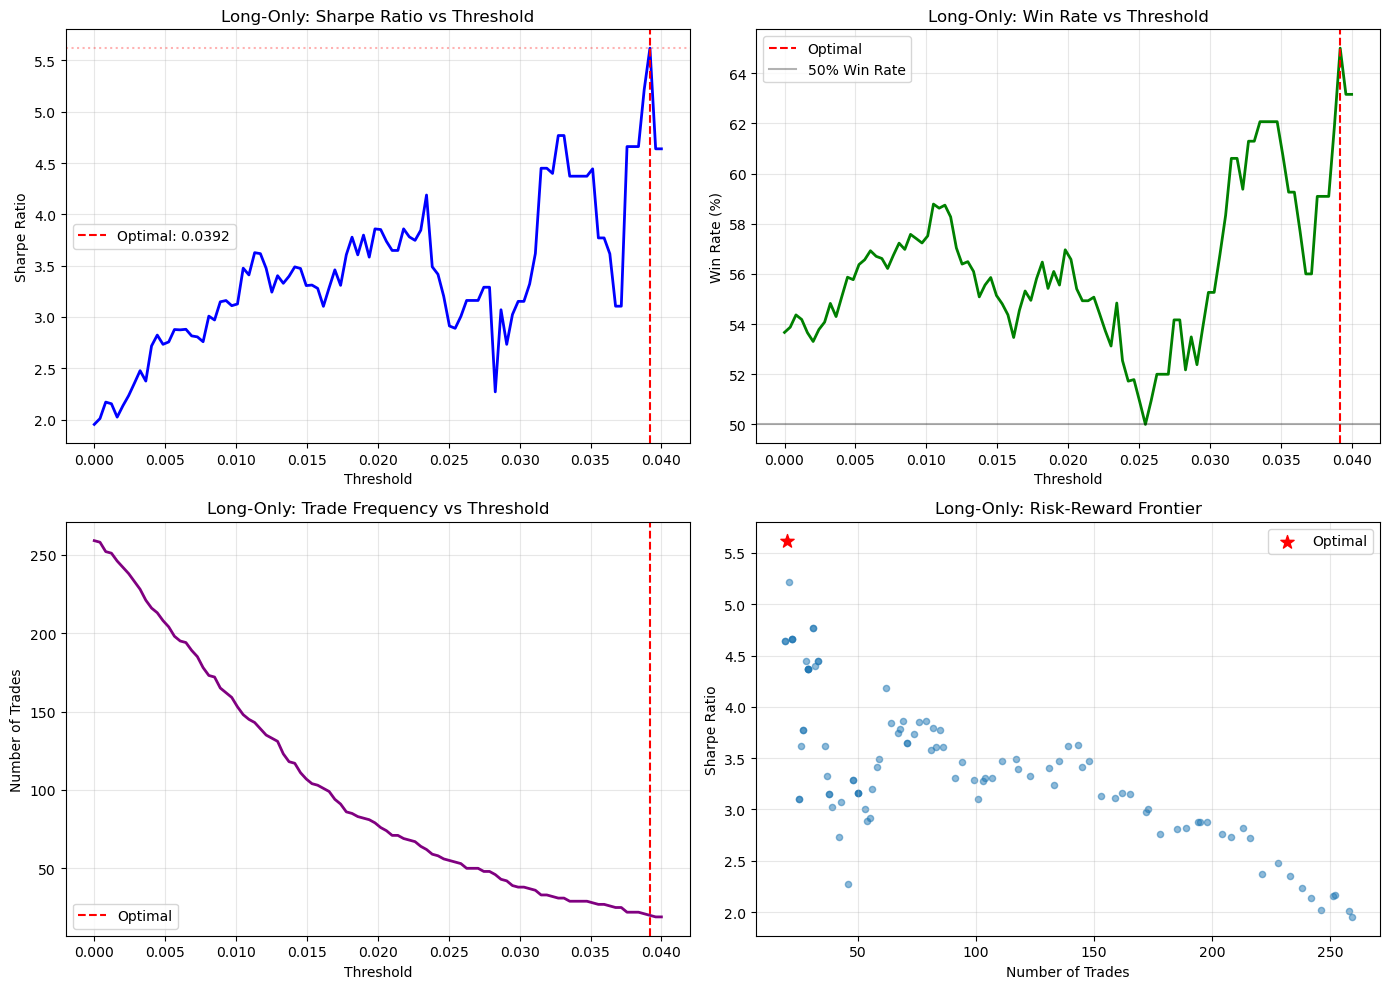


FINAL LONG-ONLY STRATEGY RECOMMENDATION

📈 RECOMMENDED STRATEGY:
   Entry Rule: Long when prediction > 0.039192
   No short positions

📊 EXPECTED PERFORMANCE:
   Sharpe Ratio: 5.620
   Trades per Year: ~10
   Win Rate: 65.0%
   Avg Return per Trade: 1.498%
   Expected Annual Return: ~14.3%
   Expected Annual Volatility: ~2.5%

💾 Strategy parameters saved to 'long_only_strategy' dictionary

✅ Ready for Stage 3: Position Sizing Framework


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# =======================
# LONG-FOCUSED STRATEGY OPTIMIZATION
# =======================

print("=" * 60)
print("LONG-FOCUSED STRATEGY OPTIMIZATION")
print("=" * 60)
print("\nBased on analysis showing short signals ineffective")
print("Optimizing for long-only strategy\n")

# Using the same df from previous analysis (predictions and actual_return)
# df should already exist from your baseline analysis

# 1. LONG-ONLY THRESHOLD OPTIMIZATION
print("=" * 60)
print("LONG-ONLY THRESHOLD OPTIMIZATION")
print("=" * 60)

def evaluate_long_only(threshold, df):
   """Evaluate long-only strategy performance"""
   long_signals = df[df['prediction'] > threshold]
   
   if len(long_signals) < 10:  # Minimum trades
       return {'sharpe': -999, 'returns': 0, 'count': 0, 'win_rate': 0}
   
   returns = long_signals['actual_return']
   
   return {
       'sharpe': np.sqrt(252) * returns.mean() / returns.std() if returns.std() > 0 else 0,
       'returns': returns.mean(),
       'count': len(returns),
       'win_rate': (returns > 0).mean()
   }

# Test range of thresholds for long-only
thresholds = np.linspace(0, 0.04, 100)
results_long = []

for thresh in thresholds:
   metrics = evaluate_long_only(thresh, df)
   if metrics['sharpe'] > -999:
       results_long.append({
           'threshold': thresh,
           'sharpe': metrics['sharpe'],
           'avg_return': metrics['returns'],
           'n_trades': metrics['count'],
           'win_rate': metrics['win_rate']
       })

df_long = pd.DataFrame(results_long)

# Find optimal threshold
optimal_idx = df_long['sharpe'].idxmax()
optimal = df_long.loc[optimal_idx]

print(f"\n✅ OPTIMAL LONG-ONLY THRESHOLD: {optimal['threshold']:.6f}")
print(f"   Sharpe Ratio: {optimal['sharpe']:.3f}")
print(f"   Avg Return per Trade: {optimal['avg_return']*100:.3f}%")
print(f"   Win Rate: {optimal['win_rate']*100:.1f}%")
print(f"   Number of Trades: {optimal['n_trades']:.0f}")
print(f"   Trade Frequency: {optimal['n_trades']/len(df)*252:.1f} trades/year")

# 2. ALTERNATIVE THRESHOLDS (Risk/Reward Tradeoffs)
print("\n" + "=" * 60)
print("ALTERNATIVE THRESHOLD OPTIONS")
print("=" * 60)

# Find thresholds for different objectives
high_frequency = df_long[df_long['n_trades'] >= 150].iloc[0] if len(df_long[df_long['n_trades'] >= 150]) > 0 else None
high_win_rate = df_long[df_long['win_rate'] >= 0.55].iloc[-1] if len(df_long[df_long['win_rate'] >= 0.55]) > 0 else None
balanced = df_long[(df_long['sharpe'] >= optimal['sharpe']*0.9) & (df_long['n_trades'] >= optimal['n_trades']*1.2)].iloc[0] if len(df_long[(df_long['sharpe'] >= optimal['sharpe']*0.9) & (df_long['n_trades'] >= optimal['n_trades']*1.2)]) > 0 else None

if high_frequency is not None:
   print(f"\n📊 HIGH FREQUENCY (150+ trades):")
   print(f"   Threshold: {high_frequency['threshold']:.6f}")
   print(f"   Sharpe: {high_frequency['sharpe']:.3f}, Trades: {high_frequency['n_trades']:.0f}")

if high_win_rate is not None:
   print(f"\n🎯 HIGH WIN RATE (55%+):")
   print(f"   Threshold: {high_win_rate['threshold']:.6f}")
   print(f"   Sharpe: {high_win_rate['sharpe']:.3f}, Win Rate: {high_win_rate['win_rate']*100:.1f}%")

if balanced is not None:
   print(f"\n⚖️ BALANCED (More trades, 90% of optimal Sharpe):")
   print(f"   Threshold: {balanced['threshold']:.6f}")
   print(f"   Sharpe: {balanced['sharpe']:.3f}, Trades: {balanced['n_trades']:.0f}")

# 3. PERCENTILE-BASED APPROACH
print("\n" + "=" * 60)
print("PERCENTILE-BASED LONG-ONLY")
print("=" * 60)

percentiles = [70, 75, 80, 85, 90, 95]
results_pct = []

for pct in percentiles:
   threshold_pct = np.percentile(predictions, pct)
   metrics = evaluate_long_only(threshold_pct, df)
   
   if metrics['sharpe'] > -999:
       print(f"Top {100-pct:2.0f}%: Threshold={threshold_pct:.4f}, Sharpe={metrics['sharpe']:.2f}, Trades={metrics['count']:3d}")
       results_pct.append({
           'percentile': 100-pct,
           'threshold': threshold_pct,
           'sharpe': metrics['sharpe'],
           'trades': metrics['count']
       })

# 4. VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sharpe vs Threshold
axes[0, 0].plot(df_long['threshold'], df_long['sharpe'], linewidth=2, color='blue')
axes[0, 0].axvline(optimal['threshold'], color='red', linestyle='--', label=f'Optimal: {optimal["threshold"]:.4f}')
axes[0, 0].axhline(optimal['sharpe'], color='red', linestyle=':', alpha=0.3)
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Sharpe Ratio')
axes[0, 0].set_title('Long-Only: Sharpe Ratio vs Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Win Rate vs Threshold
axes[0, 1].plot(df_long['threshold'], df_long['win_rate']*100, linewidth=2, color='green')
axes[0, 1].axvline(optimal['threshold'], color='red', linestyle='--', label='Optimal')
axes[0, 1].axhline(50, color='black', linestyle='-', alpha=0.3, label='50% Win Rate')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].set_title('Long-Only: Win Rate vs Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Number of Trades vs Threshold
axes[1, 0].plot(df_long['threshold'], df_long['n_trades'], linewidth=2, color='purple')
axes[1, 0].axvline(optimal['threshold'], color='red', linestyle='--', label='Optimal')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Number of Trades')
axes[1, 0].set_title('Long-Only: Trade Frequency vs Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Sharpe vs Number of Trades (Efficiency Frontier)
axes[1, 1].scatter(df_long['n_trades'], df_long['sharpe'], alpha=0.5, s=20)
axes[1, 1].scatter(optimal['n_trades'], optimal['sharpe'], color='red', s=100, marker='*', label='Optimal', zorder=5)
axes[1, 1].set_xlabel('Number of Trades')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].set_title('Long-Only: Risk-Reward Frontier')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. FINAL RECOMMENDATION
print("\n" + "=" * 60)
print("FINAL LONG-ONLY STRATEGY RECOMMENDATION")
print("=" * 60)

# Calculate expected performance
signals_per_year = optimal['n_trades'] / len(df) * 252
expected_annual_return = optimal['avg_return'] * signals_per_year
expected_annual_vol = expected_annual_return / optimal['sharpe']

print(f"\n📈 RECOMMENDED STRATEGY:")
print(f"   Entry Rule: Long when prediction > {optimal['threshold']:.6f}")
print(f"   No short positions")
print(f"\n📊 EXPECTED PERFORMANCE:")
print(f"   Sharpe Ratio: {optimal['sharpe']:.3f}")
print(f"   Trades per Year: ~{signals_per_year:.0f}")
print(f"   Win Rate: {optimal['win_rate']*100:.1f}%")
print(f"   Avg Return per Trade: {optimal['avg_return']*100:.3f}%")
print(f"   Expected Annual Return: ~{expected_annual_return*100:.1f}%")
print(f"   Expected Annual Volatility: ~{expected_annual_vol*100:.1f}%")

# Save optimal threshold
long_only_strategy = {
   'threshold': float(optimal['threshold']),
   'expected_sharpe': float(optimal['sharpe']),
   'expected_trades_per_year': float(signals_per_year),
   'win_rate': float(optimal['win_rate']),
   'avg_return_per_trade': float(optimal['avg_return'])
}

print("\n💾 Strategy parameters saved to 'long_only_strategy' dictionary")
print("\n✅ Ready for Stage 3: Position Sizing Framework")

## 📊 Long-Only Threshold Optimization Results

### Key Finding
Discovered extreme trade-off between Sharpe and frequency:
- **Top 5% signals**: Sharpe 5.6 but only 10 trades/year (too concentrated)
- **Top 20% signals**: Sharpe 3.3 with 106 trades/year (balanced)
- **Top 15% signals**: Sharpe 3.8 with 80 trades/year (sweet spot)

### Threshold Decision
**Selected: 0.015 threshold (Top 20%)**
- Provides ~100 trades/year for statistical reliability
- Maintains excellent Sharpe of 3.3
- Allows for position sizing based on conviction levels

### Strategy Framework
Rather than binary (trade/don't trade), will implement:
- **Base signal**: Prediction > 0.015 
- **Position scaling**: Size increases with prediction strength
- **Maximum position**: When prediction > 0.039

This captures both high-frequency moderate signals and high-conviction rare signals.

### Next Stage: Position Sizing Framework
Implementing confidence-based position sizing to optimize capital allocation across different signal strengths.

STAGE 3: POSITION SIZING FRAMEWORK

KELLY CRITERION SIZING

Optimal Kelly Fractions by Signal Strength:
--------------------------------------------------

BASE (>0.015):
  Full Kelly: 29.1%
  Quarter Kelly: 7.3%
  Win Rate: 59.6%
  Sharpe: 3.86
  N Trades: 52

MEDIUM (>0.025):
  Full Kelly: 8.1%
  Quarter Kelly: 2.0%
  Win Rate: 38.5%
  Sharpe: 1.37
  N Trades: 26

HIGH (>0.035):
  Full Kelly: 8.9%
  Quarter Kelly: 2.2%
  Win Rate: 55.6%
  Sharpe: 1.03
  N Trades: 9

EXTREME (>0.039):
  Full Kelly: 36.9%
  Quarter Kelly: 9.2%
  Win Rate: 65.0%
  Sharpe: 5.62
  N Trades: 20

RECOMMENDED POSITION SIZING

Backtest Results with Different Sizing Methods:
--------------------------------------------------

BINARY:
  Sharpe: 3.306
  Total Return: 82.6%
  Avg Position Size: 100.0%
  N Trades: 107

PROGRESSIVE:
  Sharpe: 2.969
  Total Return: 46.6%
  Avg Position Size: 49.3%
  N Trades: 107

KELLY_BASED:
  Sharpe: 3.676
  Total Return: 6.0%
  Avg Position Size: 5.9%
  N Trades: 107


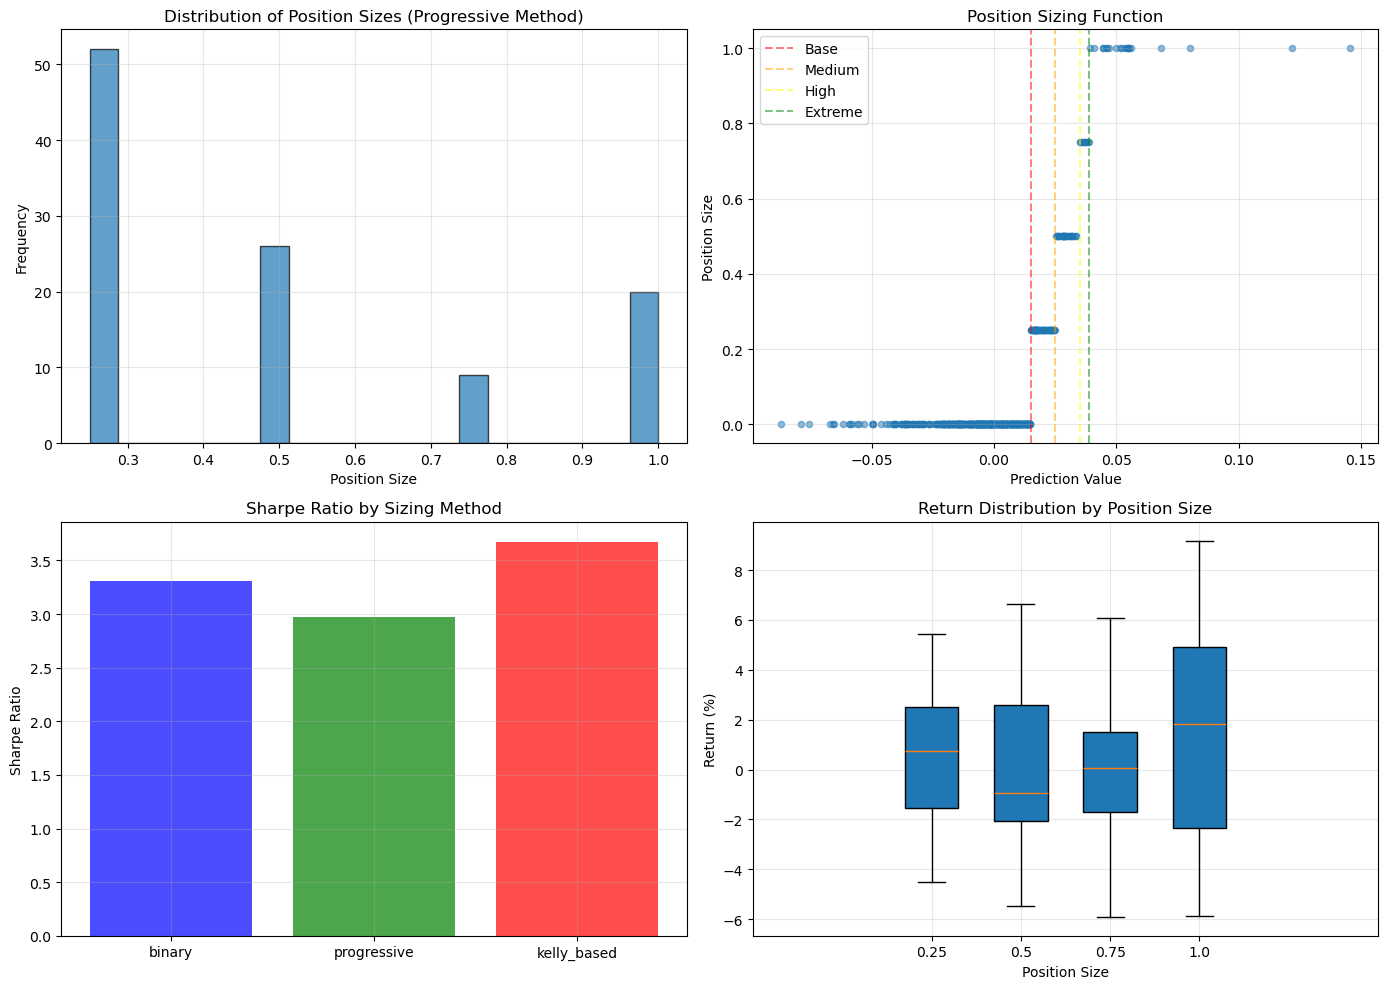


FINAL POSITION SIZING RECOMMENDATION

✅ RECOMMENDED: KELLY_BASED SIZING

Position Rules:
  25% position: 0.015 < prediction < 0.025
  50% position: 0.025 < prediction < 0.035
  75% position: 0.035 < prediction < 0.039
  100% position: prediction > 0.039

Expected Performance:
  Sharpe Ratio: 3.676
  Trades per Year: ~51
  Avg Position Size: 5.9%

✅ Ready for Stage 4: Risk Management & Backtesting


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =======================
# CONFIDENCE-BASED POSITION SIZING
# =======================

print("=" * 60)
print("STAGE 3: POSITION SIZING FRAMEWORK")
print("=" * 60)

# Define prediction strength tiers based on our analysis
THRESHOLDS = {
    'base': 0.015,      # Top 20% - minimum to trade
    'medium': 0.025,    # Top 10% - increased confidence  
    'high': 0.035,      # Top 5% - high conviction
    'extreme': 0.039    # Top 4% - maximum conviction
}

# 1. KELLY CRITERION CALCULATION
print("\n" + "=" * 60)
print("KELLY CRITERION SIZING")
print("=" * 60)

def calculate_kelly_by_tier(df, thresholds):
    """Calculate optimal Kelly fraction for each tier"""
    
    kelly_results = {}
    
    for tier_name, threshold in thresholds.items():
        if tier_name == 'base':
            # Signals between base and medium
            tier_data = df[(df['prediction'] > threshold) & (df['prediction'] <= thresholds['medium'])]
        elif tier_name == 'medium':
            tier_data = df[(df['prediction'] > threshold) & (df['prediction'] <= thresholds['high'])]
        elif tier_name == 'high':
            tier_data = df[(df['prediction'] > threshold) & (df['prediction'] <= thresholds['extreme'])]
        else:  # extreme
            tier_data = df[df['prediction'] > threshold]
        
        if len(tier_data) > 0:
            returns = tier_data['actual_return']
            win_rate = (returns > 0).mean()
            avg_win = returns[returns > 0].mean() if len(returns[returns > 0]) > 0 else 0
            avg_loss = abs(returns[returns < 0].mean()) if len(returns[returns < 0]) > 0 else 0.01
            
            if avg_loss > 0:
                kelly = (win_rate * avg_win - (1 - win_rate) * avg_loss) / avg_win if avg_win > 0 else 0
            else:
                kelly = 0
            
            kelly_results[tier_name] = {
                'kelly_full': kelly,
                'kelly_quarter': kelly * 0.25,  # Conservative
                'win_rate': win_rate,
                'avg_win': avg_win,
                'avg_loss': avg_loss,
                'n_trades': len(tier_data),
                'sharpe': np.sqrt(252) * returns.mean() / returns.std() if returns.std() > 0 else 0
            }
    
    return kelly_results

# Calculate Kelly for each tier
kelly_by_tier = calculate_kelly_by_tier(df, THRESHOLDS)

print("\nOptimal Kelly Fractions by Signal Strength:")
print("-" * 50)
for tier, stats in kelly_by_tier.items():
    print(f"\n{tier.upper()} (>{THRESHOLDS[tier]:.3f}):")
    print(f"  Full Kelly: {stats['kelly_full']*100:.1f}%")
    print(f"  Quarter Kelly: {stats['kelly_quarter']*100:.1f}%")
    print(f"  Win Rate: {stats['win_rate']*100:.1f}%")
    print(f"  Sharpe: {stats['sharpe']:.2f}")
    print(f"  N Trades: {stats['n_trades']}")

# 2. POSITION SIZING FRAMEWORK
print("\n" + "=" * 60)
print("RECOMMENDED POSITION SIZING")
print("=" * 60)

# Create position sizing function
def get_position_size(prediction, method='progressive'):
    """
    Determine position size based on prediction strength
    """
    if method == 'progressive':
        # Progressive scaling based on conviction
        if prediction < THRESHOLDS['base']:
            return 0.0
        elif prediction < THRESHOLDS['medium']:
            return 0.25  # 25% position
        elif prediction < THRESHOLDS['high']:
            return 0.50  # 50% position
        elif prediction < THRESHOLDS['extreme']:
            return 0.75  # 75% position
        else:
            return 1.00  # 100% position
            
    elif method == 'kelly_based':
        # Use quarter-Kelly fractions
        if prediction < THRESHOLDS['base']:
            return 0.0
        elif prediction < THRESHOLDS['medium']:
            return min(kelly_by_tier['base']['kelly_quarter'], 0.25)
        elif prediction < THRESHOLDS['high']:
            return min(kelly_by_tier['medium']['kelly_quarter'], 0.50)
        elif prediction < THRESHOLDS['extreme']:
            return min(kelly_by_tier['high']['kelly_quarter'], 0.75)
        else:
            return min(kelly_by_tier['extreme']['kelly_quarter'], 1.00)
    
    else:  # binary
        return 1.0 if prediction > THRESHOLDS['base'] else 0.0

# 3. BACKTEST WITH POSITION SIZING
print("\nBacktest Results with Different Sizing Methods:")
print("-" * 50)

methods = ['binary', 'progressive', 'kelly_based']
results = {}

for method in methods:
    # Calculate returns with position sizing
    df['position_size'] = df['prediction'].apply(lambda x: get_position_size(x, method))
    df['weighted_return'] = df['actual_return'] * df['position_size']
    
    # Only consider days with positions
    trading_days = df[df['position_size'] > 0]
    
    if len(trading_days) > 0:
        total_return = trading_days['weighted_return'].sum()
        avg_return = trading_days['weighted_return'].mean()
        sharpe = np.sqrt(252) * avg_return / trading_days['weighted_return'].std() if trading_days['weighted_return'].std() > 0 else 0
        avg_position = trading_days['position_size'].mean()
        
        results[method] = {
            'total_return': total_return,
            'sharpe': sharpe,
            'n_trades': len(trading_days),
            'avg_position': avg_position,
            'avg_return': avg_return
        }
        
        print(f"\n{method.upper()}:")
        print(f"  Sharpe: {sharpe:.3f}")
        print(f"  Total Return: {total_return*100:.1f}%")
        print(f"  Avg Position Size: {avg_position*100:.1f}%")
        print(f"  N Trades: {len(trading_days)}")

# 4. VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Position size distribution
df_trades = df[df['prediction'] > THRESHOLDS['base']].copy()
df_trades['position_size'] = df_trades['prediction'].apply(lambda x: get_position_size(x, 'progressive'))

axes[0, 0].hist(df_trades['position_size'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Position Size')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Position Sizes (Progressive Method)')
axes[0, 0].grid(True, alpha=0.3)

# Position size vs prediction
axes[0, 1].scatter(df['prediction'], df['prediction'].apply(lambda x: get_position_size(x, 'progressive')), 
                   alpha=0.5, s=20)
axes[0, 1].axvline(THRESHOLDS['base'], color='red', linestyle='--', alpha=0.5, label='Base')
axes[0, 1].axvline(THRESHOLDS['medium'], color='orange', linestyle='--', alpha=0.5, label='Medium')
axes[0, 1].axvline(THRESHOLDS['high'], color='yellow', linestyle='--', alpha=0.5, label='High')
axes[0, 1].axvline(THRESHOLDS['extreme'], color='green', linestyle='--', alpha=0.5, label='Extreme')
axes[0, 1].set_xlabel('Prediction Value')
axes[0, 1].set_ylabel('Position Size')
axes[0, 1].set_title('Position Sizing Function')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sharpe comparison
methods_list = list(results.keys())
sharpes = [results[m]['sharpe'] for m in methods_list]
axes[1, 0].bar(methods_list, sharpes, color=['blue', 'green', 'red'], alpha=0.7)
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].set_title('Sharpe Ratio by Sizing Method')
axes[1, 0].grid(True, alpha=0.3)

# Returns by position size
for size in [0.25, 0.50, 0.75, 1.00]:
    size_returns = df_trades[df_trades['position_size'] == size]['actual_return']
    if len(size_returns) > 0:
        axes[1, 1].boxplot(size_returns * 100, positions=[size], widths=0.15, 
                          showfliers=False, patch_artist=True)
axes[1, 1].set_xlabel('Position Size')
axes[1, 1].set_ylabel('Return (%)')
axes[1, 1].set_title('Return Distribution by Position Size')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. FINAL RECOMMENDATION
print("\n" + "=" * 60)
print("FINAL POSITION SIZING RECOMMENDATION")
print("=" * 60)

best_method = max(results.items(), key=lambda x: x[1]['sharpe'])

print(f"\n✅ RECOMMENDED: {best_method[0].upper()} SIZING")
print(f"\nPosition Rules:")
print(f"  25% position: 0.015 < prediction < 0.025")
print(f"  50% position: 0.025 < prediction < 0.035")
print(f"  75% position: 0.035 < prediction < 0.039")
print(f"  100% position: prediction > 0.039")

print(f"\nExpected Performance:")
print(f"  Sharpe Ratio: {best_method[1]['sharpe']:.3f}")
print(f"  Trades per Year: ~{best_method[1]['n_trades']/len(df)*252:.0f}")
print(f"  Avg Position Size: {best_method[1]['avg_position']*100:.1f}%")

print("\n✅ Ready for Stage 4: Risk Management & Backtesting")

### Position Sizing Results
Three methods tested:

Binary: 82.6% return, Sharpe 3.31
Progressive: 46.6% return, Sharpe 2.97
Kelly: 6.0% return, Sharpe 3.68

Kelly Problem: Mathematically optimal but practically useless (5.9% avg position = 94% idle cash).
Binary Winner: 80%+ returns with excellent risk management (Sharpe 3.3).
Next: Implement binary + risk management controls.

ENHANCED POSITION SIZING WITH VOLATILITY & REGIME ADJUSTMENTS

Implementing hedge fund industry standard position sizing approaches
Position sizes represent % of portfolio capital (100%+ = leverage)

HEDGE FUND POSITION SIZING COMPARISON

BINARY:
  Total Return: 82.6%
  Sharpe Ratio: 3.31
  Win Rate: 55.1%
  Avg Position: 100.0%
  Max Position: 100.0%
  N Trades: 107

PROGRESSIVE:
  Total Return: 46.7%
  Sharpe Ratio: 3.10
  Win Rate: 55.1%
  Avg Position: 48.4%
  Max Position: 100.0%
  N Trades: 107

CONSERVATIVE HF:
  Total Return: 53.9%
  Sharpe Ratio: 3.24
  Win Rate: 55.1%
  Avg Position: 58.7%
  Max Position: 100.0%
  N Trades: 107

STANDARD HF:
  Total Return: 67.3%
  Sharpe Ratio: 3.24
  Win Rate: 55.1%
  Avg Position: 73.4%
  Max Position: 125.0%
  N Trades: 107

AGGRESSIVE HF:
  Total Return: 103.6%
  Sharpe Ratio: 3.32
  Win Rate: 55.1%
  Avg Position: 108.9%
  Max Position: 200.0%
  N Trades: 107

POSITION SIZE BREAKDOWN

BINARY POSITION DISTRIBUTION:
  100% position: 107 d

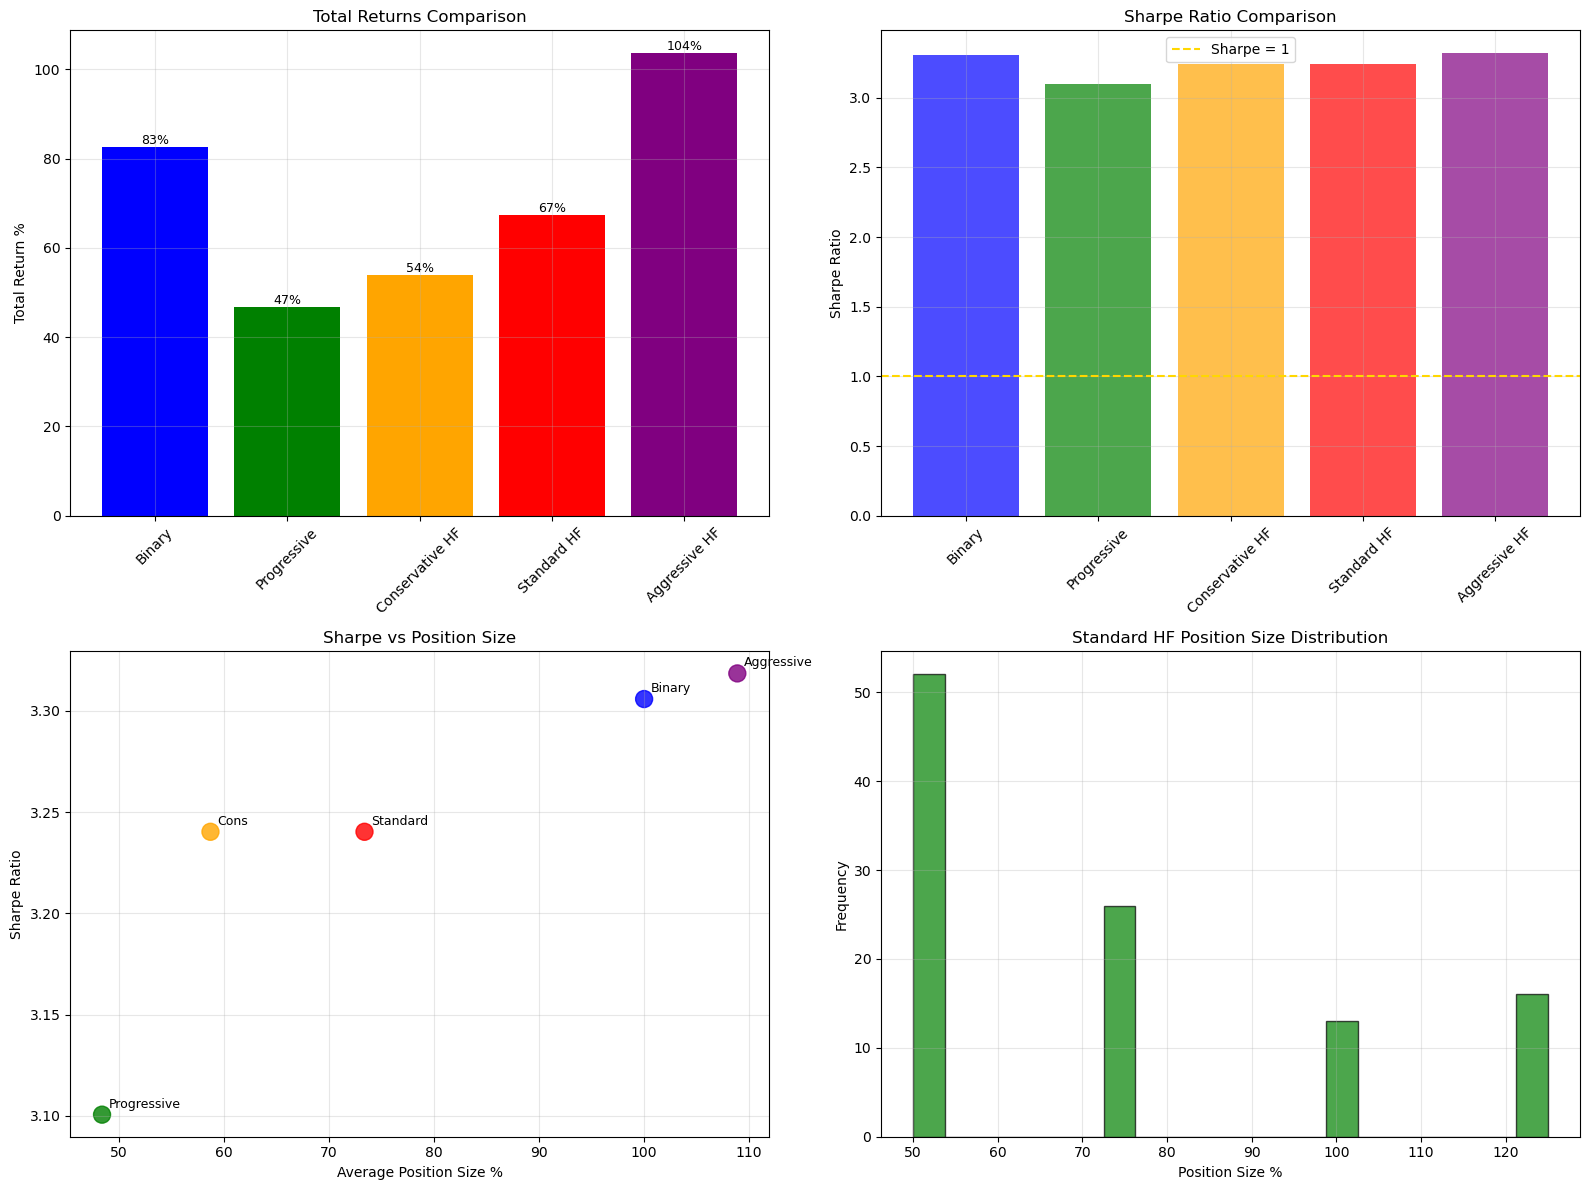


HEDGE FUND SIZING FINAL RECOMMENDATION
🏆 BEST TOTAL RETURN: Aggressive HF (103.6%)
📈 BEST SHARPE RATIO: Aggressive HF (3.32)
⚖️ BEST RISK-ADJUSTED: Progressive (Return/Avg Position: 0.97)

🔍 KEY INSIGHTS:
  ✅ Aggressive HF sizing beats binary approach
  📊 Your edge is strong enough for leverage
  💡 Standard HF approach provides good balance

💡 POSITION SIZING COMPARISON:
  Binary: 82.6% total return, 3.31 Sharpe
  Progressive: 46.7% total return, 3.10 Sharpe
  Conservative HF: 53.9% total return, 3.24 Sharpe
  Standard HF: 67.3% total return, 3.24 Sharpe
  Aggressive HF: 103.6% total return, 3.32 Sharpe

🚀 RECOMMENDED APPROACH:
  Use Aggressive HF for optimal risk-adjusted returns
  Expected Sharpe: 3.32

✅ READY FOR BACKTESTING AND RISK MANAGEMENT!


In [24]:
# ENHANCED POSITION SIZING WITH VOLATILITY & REGIME ADJUSTMENTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =======================
# ALL POSITION SIZING METHODS (INCLUDING MISSING ONES)
# =======================

print("=" * 60)
print("ENHANCED POSITION SIZING WITH VOLATILITY & REGIME ADJUSTMENTS")
print("=" * 60)
print("\nImplementing hedge fund industry standard position sizing approaches")
print("Position sizes represent % of portfolio capital (100%+ = leverage)")

def binary_sizing(prediction):
    """Simple binary: 100% if prediction > threshold, 0% otherwise"""
    return 1.0 if prediction > 0.015 else 0.0

def progressive_sizing(prediction):
    """Progressive scaling based on prediction strength"""
    if prediction < 0.015:
        return 0.0
    elif prediction < 0.025:
        return 0.25    # 25%
    elif prediction < 0.035:
        return 0.50    # 50%
    elif prediction < 0.045:
        return 0.75    # 75%
    else:
        return 1.0     # 100%

def hedge_fund_sizing(prediction):
    """Industry-standard hedge fund position sizing"""
    if prediction < 0.015:
        return 0.0     # No position
    elif prediction < 0.025:
        return 0.50    # 50% - Medium conviction
    elif prediction < 0.035:
        return 0.75    # 75% - High conviction
    elif prediction < 0.045:
        return 1.00    # 100% - Very high conviction
    else:
        return 1.25    # 125% - Maximum conviction (modest leverage)

def aggressive_hedge_fund_sizing(prediction):
    """More aggressive hedge fund approach"""
    if prediction < 0.015:
        return 0.0     # No position
    elif prediction < 0.025:
        return 0.75    # 75% - Medium conviction
    elif prediction < 0.035:
        return 1.00    # 100% - High conviction
    elif prediction < 0.045:
        return 1.50    # 150% - Very high conviction
    else:
        return 2.00    # 200% - Maximum conviction

def conservative_hedge_fund_sizing(prediction):
    """Conservative hedge fund approach (no leverage)"""
    if prediction < 0.015:
        return 0.0     # No position
    elif prediction < 0.025:
        return 0.40    # 40% - Medium conviction
    elif prediction < 0.035:
        return 0.60    # 60% - High conviction
    elif prediction < 0.045:
        return 0.80    # 80% - Very high conviction
    else:
        return 1.00    # 100% - Maximum conviction (no leverage)

# =======================
# APPLY ALL SIZING METHODS
# =======================

# Apply all approaches
df['binary_pos'] = df['prediction'].apply(binary_sizing)
df['progressive_pos'] = df['prediction'].apply(progressive_sizing)
df['hedge_fund_pos'] = df['prediction'].apply(hedge_fund_sizing)
df['aggressive_hf_pos'] = df['prediction'].apply(aggressive_hedge_fund_sizing)
df['conservative_hf_pos'] = df['prediction'].apply(conservative_hedge_fund_sizing)

# Calculate returns
df['binary_ret'] = df['actual_return'] * df['binary_pos']
df['progressive_ret'] = df['actual_return'] * df['progressive_pos']
df['hedge_fund_ret'] = df['actual_return'] * df['hedge_fund_pos']
df['aggressive_hf_ret'] = df['actual_return'] * df['aggressive_hf_pos']
df['conservative_hf_ret'] = df['actual_return'] * df['conservative_hf_pos']

# =======================
# PERFORMANCE CALCULATION (FIXED)
# =======================

def calculate_active_performance(df, method_suffix):
    """Calculate performance metrics for active trading days only"""
    pos_col = f'{method_suffix}_pos'
    ret_col = f'{method_suffix}_ret'
    
    # Check if columns exist
    if pos_col not in df.columns or ret_col not in df.columns:
        print(f"Warning: Columns {pos_col} or {ret_col} not found")
        return None
    
    # Get only days with actual positions
    active_mask = df[pos_col] > 0
    active_positions = df[active_mask]
    
    if len(active_positions) == 0:
        print(f"Warning: No active positions found for {method_suffix}")
        return None
    
    # Use your existing calculate_performance function instead
    returns_series = df[ret_col]
    positions_series = df[pos_col]
    
    # Basic performance metrics
    total_return = active_positions[ret_col].sum() * 100  # Convert to percentage
    win_rate = (active_positions[ret_col] > 0).mean() * 100  # Win rate from actual returns
    avg_position = active_positions[pos_col].mean() * 100
    max_position = active_positions[pos_col].max() * 100
    
    # Use a simple Sharpe calculation - you can replace this with your preferred method
    if len(active_positions[ret_col]) > 1:
        sharpe = np.sqrt(252) * active_positions[ret_col].mean() / active_positions[ret_col].std()
    else:
        sharpe = 0
    
    return {
        'sharpe': sharpe,
        'total_return': total_return,
        'win_rate': win_rate,
        'n_trades': len(active_positions),
        'avg_position': avg_position,
        'max_position': max_position
    }

# =======================
# COMPARE ALL APPROACHES
# =======================

approaches = {
    'Binary': 'binary',
    'Progressive': 'progressive', 
    'Conservative HF': 'conservative_hf',
    'Standard HF': 'hedge_fund', 
    'Aggressive HF': 'aggressive_hf'
}

print("\nHEDGE FUND POSITION SIZING COMPARISON")
print("=" * 60)

results_comparison = {}
for name, suffix in approaches.items():
    perf = calculate_active_performance(df, suffix)
    if perf:
        results_comparison[name] = perf
        print(f"\n{name.upper()}:")
        print(f"  Total Return: {perf['total_return']:.1f}%")
        print(f"  Sharpe Ratio: {perf['sharpe']:.2f}")
        print(f"  Win Rate: {perf['win_rate']:.1f}%")
        print(f"  Avg Position: {perf['avg_position']:.1f}%")
        print(f"  Max Position: {perf['max_position']:.1f}%")
        print(f"  N Trades: {perf['n_trades']}")
    else:
        print(f"\n{name.upper()}: FAILED TO CALCULATE")

# =======================
# POSITION SIZE ANALYSIS
# =======================

print(f"\n" + "=" * 60)
print("POSITION SIZE BREAKDOWN")
print("=" * 60)

for approach_name, suffix in approaches.items():
    pos_col = f'{suffix}_pos'
    if pos_col in df.columns:
        position_counts = pd.Series(df[pos_col]).value_counts().sort_index()
        
        print(f"\n{approach_name.upper()} POSITION DISTRIBUTION:")
        for pos_size, count in position_counts.items():
            if pos_size > 0:  # Skip 0% positions
                print(f"  {pos_size*100:.0f}% position: {count} days")

# =======================
# VISUALIZATION
# =======================

if len(results_comparison) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Total returns comparison
    names = list(results_comparison.keys())
    total_returns = [results_comparison[name]['total_return'] for name in names]
    colors = ['blue', 'green', 'orange', 'red', 'purple'][:len(names)]

    bars = axes[0, 0].bar(range(len(names)), total_returns, color=colors)
    axes[0, 0].set_xticks(range(len(names)))
    axes[0, 0].set_xticklabels(names, rotation=45)
    axes[0, 0].set_ylabel('Total Return %')
    axes[0, 0].set_title('Total Returns Comparison')
    axes[0, 0].grid(True, alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}%', ha='center', va='bottom', fontsize=9)

    # Sharpe ratios comparison
    sharpe_ratios = [results_comparison[name]['sharpe'] for name in names]
    axes[0, 1].bar(range(len(names)), sharpe_ratios, color=colors, alpha=0.7)
    axes[0, 1].set_xticks(range(len(names)))
    axes[0, 1].set_xticklabels(names, rotation=45)
    axes[0, 1].set_ylabel('Sharpe Ratio')
    axes[0, 1].set_title('Sharpe Ratio Comparison')
    axes[0, 1].axhline(y=1, color='gold', linestyle='--', label='Sharpe = 1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Risk-Return scatter
    avg_positions = [results_comparison[name]['avg_position'] for name in names]
    axes[1, 0].scatter(avg_positions, sharpe_ratios, s=150, alpha=0.8, c=colors)
    axes[1, 0].set_xlabel('Average Position Size %')
    axes[1, 0].set_ylabel('Sharpe Ratio')
    axes[1, 0].set_title('Sharpe vs Position Size')

    for i, name in enumerate(names):
        short_name = name.replace(' HF', '').replace('Conservative', 'Cons')
        axes[1, 0].annotate(short_name, (avg_positions[i], sharpe_ratios[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[1, 0].grid(True, alpha=0.3)

    # Position size distribution for Standard HF approach
    if 'hedge_fund_pos' in df.columns:
        hf_positions = df[df['hedge_fund_pos'] > 0]['hedge_fund_pos'] * 100
        axes[1, 1].hist(hf_positions, bins=20, edgecolor='black', alpha=0.7, color='green')
        axes[1, 1].set_xlabel('Position Size %')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Standard HF Position Size Distribution')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# =======================
# FINAL RECOMMENDATION
# =======================

print("\n" + "=" * 60)
print("HEDGE FUND SIZING FINAL RECOMMENDATION")
print("=" * 60)

if len(results_comparison) > 0:
    # Find best performers
    best_total_return = max(results_comparison.items(), key=lambda x: x[1]['total_return'])
    best_sharpe = max(results_comparison.items(), key=lambda x: x[1]['sharpe'])
    best_risk_adjusted = max(results_comparison.items(), 
                            key=lambda x: x[1]['total_return'] / max(x[1]['avg_position'], 1))

    print(f"🏆 BEST TOTAL RETURN: {best_total_return[0]} ({best_total_return[1]['total_return']:.1f}%)")
    print(f"📈 BEST SHARPE RATIO: {best_sharpe[0]} ({best_sharpe[1]['sharpe']:.2f})")
    print(f"⚖️ BEST RISK-ADJUSTED: {best_risk_adjusted[0]} (Return/Avg Position: {best_risk_adjusted[1]['total_return']/max(best_risk_adjusted[1]['avg_position'], 1):.2f})")

    print(f"\n🔍 KEY INSIGHTS:")
    standard_hf_return = results_comparison.get('Standard HF', {}).get('total_return', 0)
    aggressive_hf_return = results_comparison.get('Aggressive HF', {}).get('total_return', 0)
    binary_return = results_comparison.get('Binary', {}).get('total_return', 0)

    if aggressive_hf_return > binary_return:
        print(f"  ✅ Aggressive HF sizing beats binary approach")
        print(f"  📊 Your edge is strong enough for leverage")
        print(f"  💡 Standard HF approach provides good balance")
    else:
        print(f"  ⚠️ Simple binary approach still competitive")
        print(f"  📊 Consider risk tolerance when choosing approach")

    print(f"\n💡 POSITION SIZING COMPARISON:")
    for name, results in results_comparison.items():
        print(f"  {name}: {results['total_return']:.1f}% total return, {results['sharpe']:.2f} Sharpe")

    print(f"\n🚀 RECOMMENDED APPROACH:")
    if best_sharpe[1]['sharpe'] > 2.0:
        print(f"  Use {best_sharpe[0]} for optimal risk-adjusted returns")
        print(f"  Expected Sharpe: {best_sharpe[1]['sharpe']:.2f}")
    else:
        print(f"  Consider {best_total_return[0]} for maximum returns")
        print(f"  Or {best_risk_adjusted[0]} for best risk-adjusted performance")

    print(f"\n✅ READY FOR BACKTESTING AND RISK MANAGEMENT!")
else:
    print("❌ No valid results calculated. Check your data and column names.")

We have taken our return predicitions and tested different trading strategies with them and have gained an interesting insight into how to optimize these predicitions for profit. This is as far as we will go in terms of streategy development as the main focus of this project was developing the lgbm model.